In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import os
import datetime
import warnings
import copy
from scipy.stats import norm, skew
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def parseData(df):
    """
    预处理数据
    """
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
    #df.drop('communityName',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    
    agg_func = {
        'buildYear' : ['max','min'],
    
        'pv': ['max','min','mean'],
        'uv': ['max','min','mean'],

    }
    
    agg_trans = df.groupby(['ID']).agg(agg_func)
    agg_trans.columns = [ '_'.join(col).strip() 
                               for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    df = pd.merge(df, agg_trans, on='ID', how='left')
    
    return df

In [3]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train[df_train['area']<=700]
    df_train = df_train[df_train['tradeMoney']<=40000]
    
    df_train = df_train.drop(df_train[(df_train['region']== 'RG00004') & (df_train['tradeMoney']>30000)].index)
    df_train = df_train.drop(df_train[(df_train['region']== 'RG00009') & (df_train['tradeMoney']>40000)].index)
    
    
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00005') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00011') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00010') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00033') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00002') & (df_train['tradeMoney']>14000)].index)
    
   
    df_train.drop('ID', axis=1, inplace=True)
    df_test.drop('ID', axis=1,inplace=True)
    
    return df_train, df_test

In [4]:
def feature(df):
    """
    特征
    """
    #houseType
    df['rooms'] = df['houseType'].str.extract(r'(\d+室)', expand=False).apply(lambda x: eval(x.split('室')[0]))
    df['halls'] = df['houseType'].str.extract(r'(\d+厅)', expand=False).apply(lambda x: eval(x.split('厅')[0]))
    df['toilet'] = df['houseType'].str.extract(r'(\d+卫)', expand=False).apply(lambda x: eval(x.split('卫')[0]))

    #卧室面积
    df['roomsarea']=df['area']/df['rooms']

    
    df['houseToward'].replace(to_replace='暂无数据',value=np.nan,inplace=True)
    df['houseToward'].replace(to_replace='西',value=5,inplace=True)
    df['houseToward'].replace(to_replace='西北',value=6,inplace=True)
    df['houseToward'].replace(to_replace='北',value=4,inplace=True)
    df['houseToward'].replace(to_replace='西南',value=3,inplace=True)
    df['houseToward'].replace(to_replace='东',value=2,inplace=True)
    df['houseToward'].replace(to_replace='东西',value=2,inplace=True)
    df['houseToward'].replace(to_replace='东南',value=1,inplace=True)
    df['houseToward'].replace(to_replace='南',value=0,inplace=True)
    df['houseToward'].replace(to_replace='南北',value=0,inplace=True)
    df['houseToward'] = df['houseToward'].fillna(df['houseToward'].mean()).astype(int)
    
    df['rentType'].replace(to_replace='未知方式',value=np.nan,inplace=True)
    df['rentType'].replace(to_replace='整租',value=0,inplace=True)
    df['rentType'].replace(to_replace='合租',value=1,inplace=True)
    df['rentType'] = df['rentType'].fillna(0).astype(int)
    
    
    subway = []
    df_subway = list(copy.deepcopy(df['subwayStationNum']))
    for i in df_subway:
        if i >= df['subwayStationNum'].mean():
            subway.append(1)
        else:
            subway.append(0)
    df['subway'] = subway
    
    #楼的总面积
    total_square = []
    totalFloor = list(copy.deepcopy(df['totalFloor']))
    area = list(copy.deepcopy(df['area']))
    for i in range(len(totalFloor)):
        temp = totalFloor[i] * area[i]
        total_square.append(temp)
    df['total_square'] = total_square
     
    
    #tradeTime
    df["tradeTime"] = pd.to_datetime(df["tradeTime"])
    df['week'] = df["tradeTime"].dt.weekofyear
    df["month"] = df["tradeTime"].dt.month
    
    
    df['lgarea'] = np.log1p(df['area'])
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)
    
     #box-cox转换
    ''' numeric_feats = df.dtypes[df.dtypes != "category" ].index
    print(numeric_feats)
    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    
    skewness = skewness[abs(skewness.Skew)>0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = -0.09
    for feat in skewed_features:
        #all_data[feat] += 1
        if feat != 'tradeMoney':
            df[feat] = boxcox1p(df[feat], lam)'''
        
        
        
        
    categorical_feats = ['rentType', 'houseFloor', 'houseDecoration', 'region', 'plate','communityName']
    return df, categorical_feats

In [5]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv('../input/train_data.csv')
    test = pd.read_csv('../input/test_a.csv')
    
    train = parseData(train)
    test = parseData(test)
    
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)

    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    
    return train, test, target, features, categorical_feats

# 训练模型

In [6]:
train, test, target, features, categorical_feats = getData(feature)

In [89]:
target.describe()

count    41328.000000
mean      4747.645180
std       3597.330186
min          0.000000
25%       2800.000000
50%       4000.000000
75%       5400.000000
max      40000.000000
Name: tradeMoney, dtype: float64

In [7]:
plt.clf()
plt.figure(figsize=(500,10))
plt.scatter(x=train.loc[:,'communityName'],y=target)
plt.show()

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

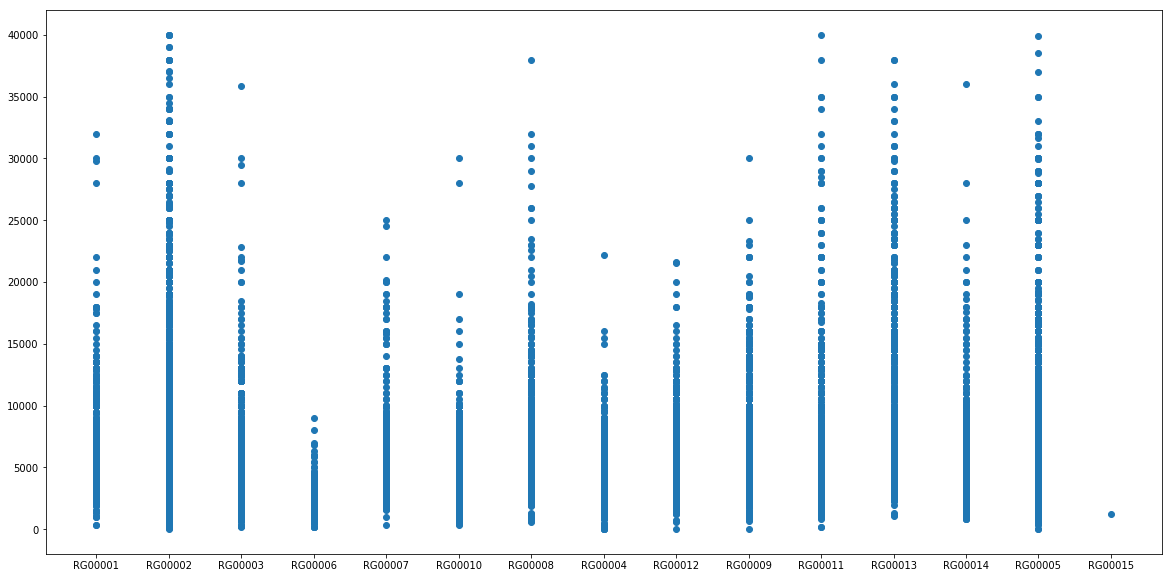

In [100]:
'''plt.clf()
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=train.loc[:,'region'],y=target)
plt.show()'''

In [7]:
train.to_csv('train_other.csv',encoding = 'gbk')
test.to_csv('test_other.csv',encoding = 'gbk')

In [8]:
'''train = pd.read_csv('train_other.csv',encoding = 'gbk')
test = pd.read_csv('test_other.csv',encoding = 'gbk')'''

"train = pd.read_csv('train_other.csv',encoding = 'gbk')\ntest = pd.read_csv('test_other.csv',encoding = 'gbk')"

In [21]:
features

Index(['area', 'rentType', 'houseFloor', 'totalFloor', 'houseToward',
       'houseDecoration', 'region', 'plate', 'buildYear', 'saleSecHouseNum',
       'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum',
       'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum',
       'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney',
       'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum',
       'buildYear_max', 'buildYear_min', 'pv_max', 'pv_min', 'pv_mean',
       'uv_max', 'uv_min', 'uv_mean', 'rooms', 'halls', 'toilet', 'roomsarea',
       'subway', 'total_square', 'lgtotal_square', 'week', 'month', 'lgarea'],
      dtype='obje

In [38]:
categorical_feats

['rentType', 'houseFloor', 'houseDecoration', 'region', 'plate']

In [12]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
import optuna
import gc


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def objective(trial):
        num_folds = 5
        
        train_x, train_y = train, target
        #data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
        '''dtrain = lgb.Dataset(train_x, label=train_y)'''
        
       
        lgbm_train = lgb.Dataset(train_x,
                                 train_y,
                                  free_raw_data=False
                                  )
        params = {'objective': 'regression',
                  'metric': 'rmse',
                  'verbosity': -1,
                  "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 0.05),
                  
                  
                  
                  'seed': 2223,
                  "bagging_freq": 1,
                  "bagging_fraction": 0.85,
                  "bagging_seed": 23,
                  "boosting": "gbdt",
                  'num_leaves': trial.suggest_int('num_leaves', 16, 200),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64),
                  'min_child_samples' : trial.suggest_int('min_child_samples', 1, 200),
                  'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.001, 1),
                  }

        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
        #folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)


        clf = lgb.cv(
                        params,
                        lgbm_train,
                        metrics=['rmse'],
                        nfold=num_folds,
                        folds=folds.split(train, target),
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100,
                        seed=47
            
                         )
        gc.collect()
        return clf['rmse-mean'][-1]



In [13]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

hist_df = study.trials_dataframe()
hist_df.to_csv("optuna_result_lgbm.csv")

del df
gc.collect()

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[100]	cv_agg's rmse: 1319.23 + 104.531
[200]	cv_agg's rmse: 1203.17 + 99.951
[300]	cv_agg's rmse: 1173.97 + 100.222
[400]	cv_agg's rmse: 1163.07 + 100.058
[500]	cv_agg's rmse: 1156.15 + 100.741
[600]	cv_agg's rmse: 1153.2 + 100.376
[700]	cv_agg's rmse: 1150.73 + 100.429
[800]	cv_agg's rmse: 1150.22 + 99.1006
[900]	cv_agg's rmse: 1150.16 + 99.074
[1000]	cv_agg's rmse: 1150.27 + 98.8302
[1100]	cv_agg's rmse: 1149.35 + 98.9865
[1200]	cv_agg's rmse: 1150.17 + 98.7773


[I 2019-05-07 23:58:42,097] Finished a trial resulted in value: 1149.2368661707844. Current best value is 1149.2368661707844 with parameters: {'learning_rate': 0.027129595580481402, 'num_leaves': 80, 'min_data_in_leaf': 50, 'min_child_samples': 36, 'feature_fraction': 0.2873446775004888}.


[100]	cv_agg's rmse: 1535.4 + 110.692
[200]	cv_agg's rmse: 1247.23 + 104.388
[300]	cv_agg's rmse: 1193.19 + 102.624
[400]	cv_agg's rmse: 1173.99 + 102.29
[500]	cv_agg's rmse: 1163.52 + 102.812
[600]	cv_agg's rmse: 1157.42 + 102.513
[700]	cv_agg's rmse: 1153.89 + 102.312
[800]	cv_agg's rmse: 1150.58 + 101.673
[900]	cv_agg's rmse: 1148.55 + 101.633
[1000]	cv_agg's rmse: 1147.05 + 101.619
[1100]	cv_agg's rmse: 1146.18 + 101.203
[1200]	cv_agg's rmse: 1145.72 + 101.028
[1300]	cv_agg's rmse: 1145.23 + 100.989
[1400]	cv_agg's rmse: 1144.61 + 101.027
[1500]	cv_agg's rmse: 1144.27 + 100.857
[1600]	cv_agg's rmse: 1143.93 + 100.568
[1700]	cv_agg's rmse: 1143.76 + 100.337
[1800]	cv_agg's rmse: 1143.63 + 99.8696
[1900]	cv_agg's rmse: 1144.09 + 99.453


[I 2019-05-08 00:02:13,698] Finished a trial resulted in value: 1143.4672301463313. Current best value is 1143.4672301463313 with parameters: {'learning_rate': 0.01544124489942416, 'num_leaves': 76, 'min_data_in_leaf': 63, 'min_child_samples': 24, 'feature_fraction': 0.7504895741157313}.


[100]	cv_agg's rmse: 2133.39 + 127.645
[200]	cv_agg's rmse: 1792.13 + 115.276
[300]	cv_agg's rmse: 1586.72 + 107.723
[400]	cv_agg's rmse: 1502.52 + 104.967
[500]	cv_agg's rmse: 1449.63 + 104.076
[600]	cv_agg's rmse: 1418.68 + 102.813
[700]	cv_agg's rmse: 1382.46 + 102.178
[800]	cv_agg's rmse: 1354.58 + 100.824
[900]	cv_agg's rmse: 1335.77 + 99.4473
[1000]	cv_agg's rmse: 1323.11 + 99.7205
[1100]	cv_agg's rmse: 1309.2 + 99.9916
[1200]	cv_agg's rmse: 1297.95 + 100.112
[1300]	cv_agg's rmse: 1291.01 + 100.164
[1400]	cv_agg's rmse: 1285.25 + 100.352
[1500]	cv_agg's rmse: 1280.17 + 100.323
[1600]	cv_agg's rmse: 1276.39 + 100.496
[1700]	cv_agg's rmse: 1272.68 + 99.8989
[1800]	cv_agg's rmse: 1270.22 + 99.483
[1900]	cv_agg's rmse: 1266.39 + 99.1639
[2000]	cv_agg's rmse: 1264.19 + 99.2223
[2100]	cv_agg's rmse: 1263.16 + 99.1665
[2200]	cv_agg's rmse: 1259.85 + 98.852
[2300]	cv_agg's rmse: 1258.02 + 98.728
[2400]	cv_agg's rmse: 1256.55 + 98.7278
[2500]	cv_agg's rmse: 1255.77 + 98.6339
[2600]	cv_agg

[I 2019-05-08 00:04:12,303] Finished a trial resulted in value: 1243.2601441621935. Current best value is 1143.4672301463313 with parameters: {'learning_rate': 0.01544124489942416, 'num_leaves': 76, 'min_data_in_leaf': 63, 'min_child_samples': 24, 'feature_fraction': 0.7504895741157313}.


[100]	cv_agg's rmse: 1320.24 + 100.245
[200]	cv_agg's rmse: 1178.18 + 98.6028
[300]	cv_agg's rmse: 1153.49 + 98.757
[400]	cv_agg's rmse: 1146.17 + 99.0908
[500]	cv_agg's rmse: 1141.79 + 98.8047
[600]	cv_agg's rmse: 1140.51 + 98.1409
[700]	cv_agg's rmse: 1139.69 + 97.5808
[800]	cv_agg's rmse: 1139.45 + 97.2565
[900]	cv_agg's rmse: 1140.09 + 97.1117


[I 2019-05-08 00:05:39,523] Finished a trial resulted in value: 1139.2159207322675. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 1185.21 + 94.3887
[200]	cv_agg's rmse: 1154.42 + 95.6995
[300]	cv_agg's rmse: 1149.42 + 94.897
[400]	cv_agg's rmse: 1148.87 + 94.4402
[500]	cv_agg's rmse: 1149.4 + 95.0788


[I 2019-05-08 00:06:13,616] Finished a trial resulted in value: 1148.5705591191988. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 1196.29 + 100.032
[200]	cv_agg's rmse: 1156.56 + 98.2214
[300]	cv_agg's rmse: 1150.48 + 97.4787
[400]	cv_agg's rmse: 1150.39 + 96.6193
[500]	cv_agg's rmse: 1152.57 + 96.3079


[I 2019-05-08 00:07:19,471] Finished a trial resulted in value: 1149.8845908087121. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 2055.67 + 124.873
[200]	cv_agg's rmse: 1724.1 + 112.022
[300]	cv_agg's rmse: 1546.3 + 104.414
[400]	cv_agg's rmse: 1475.75 + 101.755
[500]	cv_agg's rmse: 1429.91 + 101.414
[600]	cv_agg's rmse: 1403.2 + 101.294
[700]	cv_agg's rmse: 1369.7 + 101.346
[800]	cv_agg's rmse: 1345.8 + 100.594
[900]	cv_agg's rmse: 1328.47 + 100.59
[1000]	cv_agg's rmse: 1317.06 + 100.868
[1100]	cv_agg's rmse: 1303.44 + 101.356
[1200]	cv_agg's rmse: 1292.54 + 102.026
[1300]	cv_agg's rmse: 1286.31 + 101.935
[1400]	cv_agg's rmse: 1280.46 + 102.118
[1500]	cv_agg's rmse: 1275.75 + 102.593
[1600]	cv_agg's rmse: 1272.08 + 102.864
[1700]	cv_agg's rmse: 1268.68 + 102.74
[1800]	cv_agg's rmse: 1265.84 + 102.563
[1900]	cv_agg's rmse: 1262.04 + 102.554
[2000]	cv_agg's rmse: 1259.62 + 102.849
[2100]	cv_agg's rmse: 1258.29 + 102.994
[2200]	cv_agg's rmse: 1254.61 + 102.679
[2300]	cv_agg's rmse: 1252.22 + 103.403
[2400]	cv_agg's rmse: 1250.16 + 103.507
[2500]	cv_agg's rmse: 1248.37 + 103.476
[2600]	cv_agg's 

[I 2019-05-08 00:09:21,220] Finished a trial resulted in value: 1218.2234274617692. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 1333.23 + 99.2894
[200]	cv_agg's rmse: 1200.25 + 97.0067
[300]	cv_agg's rmse: 1171.1 + 97.8294
[400]	cv_agg's rmse: 1160.96 + 98.096
[500]	cv_agg's rmse: 1154.18 + 99.3003
[600]	cv_agg's rmse: 1150.07 + 99.0791
[700]	cv_agg's rmse: 1147.81 + 98.4592
[800]	cv_agg's rmse: 1146.18 + 98.2933
[900]	cv_agg's rmse: 1145.21 + 98.4982
[1000]	cv_agg's rmse: 1144.64 + 98.0488
[1100]	cv_agg's rmse: 1143.73 + 98.3843
[1200]	cv_agg's rmse: 1144.17 + 97.9021
[1300]	cv_agg's rmse: 1144.46 + 97.4165


[I 2019-05-08 00:10:21,305] Finished a trial resulted in value: 1143.620577194593. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 1456.87 + 114.435
[200]	cv_agg's rmse: 1260.25 + 103.045
[300]	cv_agg's rmse: 1214.23 + 101.704
[400]	cv_agg's rmse: 1196.44 + 100.394
[500]	cv_agg's rmse: 1187.07 + 99.7725
[600]	cv_agg's rmse: 1180.44 + 99.5128
[700]	cv_agg's rmse: 1177.59 + 98.9142
[800]	cv_agg's rmse: 1175.57 + 98.1153
[900]	cv_agg's rmse: 1173 + 97.2154
[1000]	cv_agg's rmse: 1172.13 + 96.9516
[1100]	cv_agg's rmse: 1171.75 + 96.8606
[1200]	cv_agg's rmse: 1171.05 + 96.472
[1300]	cv_agg's rmse: 1170.29 + 96.5708
[1400]	cv_agg's rmse: 1170.5 + 96.3329
[1500]	cv_agg's rmse: 1170.8 + 96.3642


[I 2019-05-08 00:11:26,974] Finished a trial resulted in value: 1170.1178550399648. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 2277.12 + 126.264
[200]	cv_agg's rmse: 1669.14 + 109.502
[300]	cv_agg's rmse: 1424.06 + 104.481
[400]	cv_agg's rmse: 1321.88 + 101.414
[500]	cv_agg's rmse: 1274.89 + 100.718
[600]	cv_agg's rmse: 1244.09 + 100.756
[700]	cv_agg's rmse: 1225.53 + 100.533
[800]	cv_agg's rmse: 1213.21 + 100.58
[900]	cv_agg's rmse: 1202.36 + 100.195
[1000]	cv_agg's rmse: 1195.51 + 99.9803
[1100]	cv_agg's rmse: 1189.31 + 99.9076
[1200]	cv_agg's rmse: 1184.6 + 100.212
[1300]	cv_agg's rmse: 1180.21 + 100.194
[1400]	cv_agg's rmse: 1176.5 + 100.279
[1500]	cv_agg's rmse: 1173.79 + 100.013
[1600]	cv_agg's rmse: 1171.63 + 100.019
[1700]	cv_agg's rmse: 1169.63 + 99.8273
[1800]	cv_agg's rmse: 1167.53 + 99.8565
[1900]	cv_agg's rmse: 1166.08 + 99.7707
[2000]	cv_agg's rmse: 1165.31 + 99.842
[2100]	cv_agg's rmse: 1164.01 + 99.9797
[2200]	cv_agg's rmse: 1162.77 + 99.9013
[2300]	cv_agg's rmse: 1162.23 + 99.8246
[2400]	cv_agg's rmse: 1161.35 + 99.7927
[2500]	cv_agg's rmse: 1160.75 + 99.7022
[2600]	cv_agg

[I 2019-05-08 00:13:20,663] Finished a trial resulted in value: 1156.0036309302895. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 1422.68 + 107.351
[200]	cv_agg's rmse: 1204.26 + 100.976
[300]	cv_agg's rmse: 1168.04 + 100.358
[400]	cv_agg's rmse: 1156.84 + 100.369
[500]	cv_agg's rmse: 1151.31 + 100.274
[600]	cv_agg's rmse: 1148.62 + 99.8326
[700]	cv_agg's rmse: 1146.52 + 98.9778
[800]	cv_agg's rmse: 1145.35 + 98.4916
[900]	cv_agg's rmse: 1145.25 + 98.8612
[1000]	cv_agg's rmse: 1145.12 + 98.6734


[I 2019-05-08 00:16:56,934] Finished a trial resulted in value: 1145.0130863760867. Current best value is 1139.2159207322675 with parameters: {'learning_rate': 0.022604685220065306, 'num_leaves': 80, 'min_data_in_leaf': 40, 'min_child_samples': 134, 'feature_fraction': 0.6033052005165012}.


[100]	cv_agg's rmse: 3302.85 + 148.241
[200]	cv_agg's rmse: 3045.2 + 140.678
[300]	cv_agg's rmse: 2815.9 + 134.41
[400]	cv_agg's rmse: 2612.24 + 129.141
[500]	cv_agg's rmse: 2431.38 + 124.722
[600]	cv_agg's rmse: 2271.86 + 121.054
[700]	cv_agg's rmse: 2131.22 + 117.912
[800]	cv_agg's rmse: 2007.6 + 115.439
[900]	cv_agg's rmse: 1899.63 + 113.352
[1000]	cv_agg's rmse: 1805.37 + 111.559
[1100]	cv_agg's rmse: 1722.83 + 110.064
[1200]	cv_agg's rmse: 1651.49 + 108.862
[1300]	cv_agg's rmse: 1589.23 + 107.895
[1400]	cv_agg's rmse: 1535.23 + 106.872
[1500]	cv_agg's rmse: 1488.49 + 105.991
[1600]	cv_agg's rmse: 1448.01 + 105.317
[1700]	cv_agg's rmse: 1412.98 + 104.656
[1800]	cv_agg's rmse: 1382.44 + 104.075
[1900]	cv_agg's rmse: 1355.47 + 103.595
[2000]	cv_agg's rmse: 1331.68 + 103.012
[2100]	cv_agg's rmse: 1310.9 + 102.497
[2200]	cv_agg's rmse: 1292.39 + 101.922
[2300]	cv_agg's rmse: 1276.1 + 101.536
[2400]	cv_agg's rmse: 1261.89 + 101.107
[2500]	cv_agg's rmse: 1249.49 + 100.717
[2600]	cv_agg's

[I 2019-05-08 00:41:04,131] Finished a trial resulted in value: 1134.9752642089716. Current best value is 1134.9752642089716 with parameters: {'learning_rate': 0.001032840901460004, 'num_leaves': 133, 'min_data_in_leaf': 27, 'min_child_samples': 2, 'feature_fraction': 0.7143672150613293}.


[100]	cv_agg's rmse: 2841.73 + 134.609
[200]	cv_agg's rmse: 2308.26 + 120.483
[300]	cv_agg's rmse: 1937.05 + 112.81
[400]	cv_agg's rmse: 1683.9 + 108.152
[500]	cv_agg's rmse: 1514.16 + 105.45
[600]	cv_agg's rmse: 1402.04 + 103.552
[700]	cv_agg's rmse: 1326.57 + 101.985
[800]	cv_agg's rmse: 1273.95 + 101.018
[900]	cv_agg's rmse: 1237.58 + 100.16
[1000]	cv_agg's rmse: 1212.78 + 99.6806
[1100]	cv_agg's rmse: 1195.02 + 99.2842
[1200]	cv_agg's rmse: 1182.69 + 99.4732
[1300]	cv_agg's rmse: 1173.25 + 99.6483
[1400]	cv_agg's rmse: 1166.05 + 99.9091
[1500]	cv_agg's rmse: 1160.33 + 100.375
[1600]	cv_agg's rmse: 1155.97 + 100.621
[1700]	cv_agg's rmse: 1152.37 + 100.75
[1800]	cv_agg's rmse: 1149.34 + 100.836
[1900]	cv_agg's rmse: 1146.94 + 101.097
[2000]	cv_agg's rmse: 1145.21 + 101.221
[2100]	cv_agg's rmse: 1143.76 + 101.339
[2200]	cv_agg's rmse: 1142.51 + 101.427
[2300]	cv_agg's rmse: 1141.62 + 101.521
[2400]	cv_agg's rmse: 1140.71 + 101.633
[2500]	cv_agg's rmse: 1140.22 + 101.711
[2600]	cv_agg'

[I 2019-05-08 00:52:29,788] Finished a trial resulted in value: 1136.9487904545733. Current best value is 1134.9752642089716 with parameters: {'learning_rate': 0.001032840901460004, 'num_leaves': 133, 'min_data_in_leaf': 27, 'min_child_samples': 2, 'feature_fraction': 0.7143672150613293}.


[100]	cv_agg's rmse: 3342.53 + 149.409
[200]	cv_agg's rmse: 3119.13 + 142.97
[300]	cv_agg's rmse: 2916.62 + 137.347
[400]	cv_agg's rmse: 2734.75 + 132.554
[500]	cv_agg's rmse: 2571.22 + 128.647
[600]	cv_agg's rmse: 2425.27 + 125.265
[700]	cv_agg's rmse: 2293.88 + 122.197
[800]	cv_agg's rmse: 2177.29 + 119.566
[900]	cv_agg's rmse: 2073.35 + 116.925
[1000]	cv_agg's rmse: 1981 + 114.916
[1100]	cv_agg's rmse: 1898.49 + 113.084
[1200]	cv_agg's rmse: 1825.86 + 111.396
[1300]	cv_agg's rmse: 1760.98 + 109.823
[1400]	cv_agg's rmse: 1702.82 + 108.299
[1500]	cv_agg's rmse: 1650.68 + 106.962
[1600]	cv_agg's rmse: 1604.13 + 105.691
[1700]	cv_agg's rmse: 1562.92 + 104.444
[1800]	cv_agg's rmse: 1526.28 + 103.269
[1900]	cv_agg's rmse: 1493.84 + 102.374
[2000]	cv_agg's rmse: 1464.79 + 101.647
[2100]	cv_agg's rmse: 1439.33 + 100.955
[2200]	cv_agg's rmse: 1416.28 + 100.283
[2300]	cv_agg's rmse: 1395.64 + 99.7649
[2400]	cv_agg's rmse: 1377.04 + 99.2876
[2500]	cv_agg's rmse: 1360.47 + 98.8741
[2600]	cv_agg

[I 2019-05-08 00:59:30,734] Finished a trial resulted in value: 1165.5244402151204. Current best value is 1134.9752642089716 with parameters: {'learning_rate': 0.001032840901460004, 'num_leaves': 133, 'min_data_in_leaf': 27, 'min_child_samples': 2, 'feature_fraction': 0.7143672150613293}.


[100]	cv_agg's rmse: 2338.73 + 118.87
[200]	cv_agg's rmse: 1707.13 + 104.997
[300]	cv_agg's rmse: 1413.89 + 101.249
[400]	cv_agg's rmse: 1282.41 + 99.0902
[500]	cv_agg's rmse: 1218.12 + 98.311
[600]	cv_agg's rmse: 1186.02 + 98.3536
[700]	cv_agg's rmse: 1169.28 + 99.019
[800]	cv_agg's rmse: 1159.04 + 99.736
[900]	cv_agg's rmse: 1152.66 + 100.172
[1000]	cv_agg's rmse: 1148.57 + 100.509
[1100]	cv_agg's rmse: 1146.25 + 100.517
[1200]	cv_agg's rmse: 1144.43 + 100.605
[1300]	cv_agg's rmse: 1143.26 + 100.665
[1400]	cv_agg's rmse: 1142.58 + 100.614
[1500]	cv_agg's rmse: 1142.03 + 100.462
[1600]	cv_agg's rmse: 1141.61 + 100.545
[1700]	cv_agg's rmse: 1141.41 + 100.557
[1800]	cv_agg's rmse: 1141.42 + 100.293
[1900]	cv_agg's rmse: 1141.36 + 100.215
[2000]	cv_agg's rmse: 1141.47 + 100.07


[I 2019-05-08 01:05:24,582] Finished a trial resulted in value: 1141.301653427319. Current best value is 1134.9752642089716 with parameters: {'learning_rate': 0.001032840901460004, 'num_leaves': 133, 'min_data_in_leaf': 27, 'min_child_samples': 2, 'feature_fraction': 0.7143672150613293}.


[100]	cv_agg's rmse: 1801.76 + 111.51
[200]	cv_agg's rmse: 1332.32 + 101.946
[300]	cv_agg's rmse: 1210.21 + 99.1285
[400]	cv_agg's rmse: 1171.86 + 100.385
[500]	cv_agg's rmse: 1154.85 + 100.951
[600]	cv_agg's rmse: 1146.18 + 101.276
[700]	cv_agg's rmse: 1142.03 + 101.355
[800]	cv_agg's rmse: 1139.36 + 100.784
[900]	cv_agg's rmse: 1137.91 + 100.991
[1000]	cv_agg's rmse: 1137.25 + 101.226
[1100]	cv_agg's rmse: 1136.76 + 101.042
[1200]	cv_agg's rmse: 1136.68 + 100.862
[1300]	cv_agg's rmse: 1136.42 + 100.78
[1400]	cv_agg's rmse: 1136.8 + 100.788


[I 2019-05-08 01:08:27,050] Finished a trial resulted in value: 1136.4020257721209. Current best value is 1134.9752642089716 with parameters: {'learning_rate': 0.001032840901460004, 'num_leaves': 133, 'min_data_in_leaf': 27, 'min_child_samples': 2, 'feature_fraction': 0.7143672150613293}.


[100]	cv_agg's rmse: 1943.71 + 115.452
[200]	cv_agg's rmse: 1417.93 + 106.437
[300]	cv_agg's rmse: 1253.14 + 105.103
[400]	cv_agg's rmse: 1196.48 + 103.802
[500]	cv_agg's rmse: 1172.05 + 103.768
[600]	cv_agg's rmse: 1160.12 + 103.777
[700]	cv_agg's rmse: 1153.65 + 103.681
[800]	cv_agg's rmse: 1149.13 + 102.918
[900]	cv_agg's rmse: 1146.5 + 103.035
[1000]	cv_agg's rmse: 1144.91 + 102.679
[1100]	cv_agg's rmse: 1143.55 + 102.32
[1200]	cv_agg's rmse: 1142.66 + 102.466
[1300]	cv_agg's rmse: 1141.92 + 102.078
[1400]	cv_agg's rmse: 1141.24 + 101.764
[1500]	cv_agg's rmse: 1141.17 + 101.555
[1600]	cv_agg's rmse: 1141.05 + 101.558
[1700]	cv_agg's rmse: 1140.9 + 101.367
[1800]	cv_agg's rmse: 1140.92 + 101.163
[1900]	cv_agg's rmse: 1141.07 + 100.91


[I 2019-05-08 01:15:04,000] Finished a trial resulted in value: 1140.7449152144277. Current best value is 1134.9752642089716 with parameters: {'learning_rate': 0.001032840901460004, 'num_leaves': 133, 'min_data_in_leaf': 27, 'min_child_samples': 2, 'feature_fraction': 0.7143672150613293}.


[100]	cv_agg's rmse: 1546.95 + 107.525
[200]	cv_agg's rmse: 1228.64 + 99.2004
[300]	cv_agg's rmse: 1168.15 + 98.0249
[400]	cv_agg's rmse: 1148.78 + 99.5459
[500]	cv_agg's rmse: 1140.92 + 100.061
[600]	cv_agg's rmse: 1137.16 + 100.375
[700]	cv_agg's rmse: 1136.02 + 100.152
[800]	cv_agg's rmse: 1134.86 + 99.9707
[900]	cv_agg's rmse: 1135.07 + 100.169
[1000]	cv_agg's rmse: 1135.32 + 100.506


[I 2019-05-08 01:17:14,602] Finished a trial resulted in value: 1134.8138885761095. Current best value is 1134.8138885761095 with parameters: {'learning_rate': 0.014306020626974975, 'num_leaves': 119, 'min_data_in_leaf': 29, 'min_child_samples': 6, 'feature_fraction': 0.6591142115934528}.


[100]	cv_agg's rmse: 1482.7 + 105.081
[200]	cv_agg's rmse: 1213.02 + 98.6324
[300]	cv_agg's rmse: 1164.62 + 98.9973
[400]	cv_agg's rmse: 1149.97 + 100.074
[500]	cv_agg's rmse: 1143.27 + 100.419
[600]	cv_agg's rmse: 1140.53 + 100.427
[700]	cv_agg's rmse: 1138.97 + 100.676
[800]	cv_agg's rmse: 1138.32 + 100.357
[900]	cv_agg's rmse: 1138.42 + 99.7299
[1000]	cv_agg's rmse: 1138.8 + 99.3736


[I 2019-05-08 01:18:50,028] Finished a trial resulted in value: 1138.0670330726175. Current best value is 1134.8138885761095 with parameters: {'learning_rate': 0.014306020626974975, 'num_leaves': 119, 'min_data_in_leaf': 29, 'min_child_samples': 6, 'feature_fraction': 0.6591142115934528}.


[100]	cv_agg's rmse: 3263.51 + 147.153
[200]	cv_agg's rmse: 2976.27 + 138.967
[300]	cv_agg's rmse: 2724.8 + 132.23
[400]	cv_agg's rmse: 2505.48 + 126.692
[500]	cv_agg's rmse: 2314.58 + 122.263
[600]	cv_agg's rmse: 2149.53 + 118.687
[700]	cv_agg's rmse: 2007.43 + 115.864
[800]	cv_agg's rmse: 1885.42 + 113.534
[900]	cv_agg's rmse: 1781.34 + 111.62
[1000]	cv_agg's rmse: 1692.52 + 110.137
[1100]	cv_agg's rmse: 1616.41 + 108.841
[1200]	cv_agg's rmse: 1552.49 + 107.742
[1300]	cv_agg's rmse: 1497.88 + 106.838
[1400]	cv_agg's rmse: 1451.54 + 105.94
[1500]	cv_agg's rmse: 1412.12 + 105.297
[1600]	cv_agg's rmse: 1378.14 + 104.69
[1700]	cv_agg's rmse: 1348.77 + 104.118
[1800]	cv_agg's rmse: 1323.35 + 103.515
[1900]	cv_agg's rmse: 1301.41 + 103.089
[2000]	cv_agg's rmse: 1282.44 + 102.698
[2100]	cv_agg's rmse: 1266.35 + 102.395
[2200]	cv_agg's rmse: 1252.44 + 102.022
[2300]	cv_agg's rmse: 1240.23 + 101.703
[2400]	cv_agg's rmse: 1229.64 + 101.449
[2500]	cv_agg's rmse: 1220.58 + 101.228
[2600]	cv_agg'

[I 2019-05-08 01:45:01,281] Finished a trial resulted in value: 1136.3434339392636. Current best value is 1134.8138885761095 with parameters: {'learning_rate': 0.014306020626974975, 'num_leaves': 119, 'min_data_in_leaf': 29, 'min_child_samples': 6, 'feature_fraction': 0.6591142115934528}.


[100]	cv_agg's rmse: 1354.85 + 99.4001
[200]	cv_agg's rmse: 1178.49 + 97.2893
[300]	cv_agg's rmse: 1152.51 + 99.3809
[400]	cv_agg's rmse: 1144.73 + 99.9379
[500]	cv_agg's rmse: 1141.17 + 99.9695
[600]	cv_agg's rmse: 1139.67 + 99.6416
[700]	cv_agg's rmse: 1139.88 + 99.5231
[800]	cv_agg's rmse: 1139.72 + 99.0793


[I 2019-05-08 01:46:16,927] Finished a trial resulted in value: 1139.3420586964899. Current best value is 1134.8138885761095 with parameters: {'learning_rate': 0.014306020626974975, 'num_leaves': 119, 'min_data_in_leaf': 29, 'min_child_samples': 6, 'feature_fraction': 0.6591142115934528}.


[100]	cv_agg's rmse: 1629.77 + 109.826
[200]	cv_agg's rmse: 1255.27 + 100.189
[300]	cv_agg's rmse: 1178.87 + 98.6095
[400]	cv_agg's rmse: 1155.64 + 99.8668
[500]	cv_agg's rmse: 1146.73 + 100.227
[600]	cv_agg's rmse: 1142.92 + 99.796
[700]	cv_agg's rmse: 1141.73 + 99.2403
[800]	cv_agg's rmse: 1141.27 + 99.2995
[900]	cv_agg's rmse: 1141.55 + 99.7018
[1000]	cv_agg's rmse: 1142.3 + 99.8634


[I 2019-05-08 01:50:22,444] Finished a trial resulted in value: 1141.2401649134958. Current best value is 1134.8138885761095 with parameters: {'learning_rate': 0.014306020626974975, 'num_leaves': 119, 'min_data_in_leaf': 29, 'min_child_samples': 6, 'feature_fraction': 0.6591142115934528}.


[100]	cv_agg's rmse: 2110.16 + 118.611
[200]	cv_agg's rmse: 1527.55 + 106.755
[300]	cv_agg's rmse: 1313.74 + 102.879
[400]	cv_agg's rmse: 1229.17 + 101.269
[500]	cv_agg's rmse: 1191.65 + 100.823
[600]	cv_agg's rmse: 1172.04 + 100.536
[700]	cv_agg's rmse: 1161.31 + 100.629
[800]	cv_agg's rmse: 1154.55 + 100.287
[900]	cv_agg's rmse: 1149.96 + 100.331
[1000]	cv_agg's rmse: 1146.89 + 100.163
[1100]	cv_agg's rmse: 1144.65 + 99.8478
[1200]	cv_agg's rmse: 1143.03 + 99.9412
[1300]	cv_agg's rmse: 1141.5 + 99.8276
[1400]	cv_agg's rmse: 1140.33 + 99.7923
[1500]	cv_agg's rmse: 1139.62 + 99.4202
[1600]	cv_agg's rmse: 1139.01 + 99.4129
[1700]	cv_agg's rmse: 1138.51 + 99.4169
[1800]	cv_agg's rmse: 1137.8 + 99.0631
[1900]	cv_agg's rmse: 1137.69 + 98.9962
[2000]	cv_agg's rmse: 1137.64 + 98.7527
[2100]	cv_agg's rmse: 1137.4 + 98.6139
[2200]	cv_agg's rmse: 1137.29 + 98.4107
[2300]	cv_agg's rmse: 1137.43 + 98.2286


[I 2019-05-08 01:55:47,118] Finished a trial resulted in value: 1137.2354533749574. Current best value is 1134.8138885761095 with parameters: {'learning_rate': 0.014306020626974975, 'num_leaves': 119, 'min_data_in_leaf': 29, 'min_child_samples': 6, 'feature_fraction': 0.6591142115934528}.


[100]	cv_agg's rmse: 2570.06 + 126.759
[200]	cv_agg's rmse: 1961.45 + 113.211
[300]	cv_agg's rmse: 1612.13 + 107.551
[400]	cv_agg's rmse: 1421.18 + 103.702
[500]	cv_agg's rmse: 1312.18 + 101.696
[600]	cv_agg's rmse: 1248.98 + 99.4789
[700]	cv_agg's rmse: 1212.82 + 99.0144
[800]	cv_agg's rmse: 1189.56 + 98.8327
[900]	cv_agg's rmse: 1174.82 + 99.3726
[1000]	cv_agg's rmse: 1164.79 + 99.963
[1100]	cv_agg's rmse: 1157.08 + 100.378
[1200]	cv_agg's rmse: 1152.06 + 100.428
[1300]	cv_agg's rmse: 1147.99 + 100.825
[1400]	cv_agg's rmse: 1145.17 + 100.837
[1500]	cv_agg's rmse: 1142.97 + 100.816
[1600]	cv_agg's rmse: 1141.22 + 100.792
[1700]	cv_agg's rmse: 1139.63 + 100.813
[1800]	cv_agg's rmse: 1138.33 + 100.629
[1900]	cv_agg's rmse: 1137.36 + 100.664
[2000]	cv_agg's rmse: 1136.52 + 100.654
[2100]	cv_agg's rmse: 1136 + 100.683
[2200]	cv_agg's rmse: 1135.48 + 100.494
[2300]	cv_agg's rmse: 1135.25 + 100.561
[2400]	cv_agg's rmse: 1134.77 + 100.709
[2500]	cv_agg's rmse: 1134.58 + 100.787
[2600]	cv_agg

[I 2019-05-08 02:01:22,675] Finished a trial resulted in value: 1133.4202831707419. Current best value is 1133.4202831707419 with parameters: {'learning_rate': 0.0044383294418839005, 'num_leaves': 96, 'min_data_in_leaf': 25, 'min_child_samples': 160, 'feature_fraction': 0.5931587207843908}.


[100]	cv_agg's rmse: 1600.92 + 107.116
[200]	cv_agg's rmse: 1252.07 + 98.286
[300]	cv_agg's rmse: 1181.78 + 98.645
[400]	cv_agg's rmse: 1159.2 + 99.948
[500]	cv_agg's rmse: 1148.88 + 100.429
[600]	cv_agg's rmse: 1143.74 + 100.652
[700]	cv_agg's rmse: 1141.08 + 100.169
[800]	cv_agg's rmse: 1138.87 + 100.09
[900]	cv_agg's rmse: 1138.11 + 100.061
[1000]	cv_agg's rmse: 1137.93 + 100.098
[1100]	cv_agg's rmse: 1137.73 + 100.16
[1200]	cv_agg's rmse: 1137.78 + 99.7643
[1300]	cv_agg's rmse: 1137.89 + 99.5995


[I 2019-05-08 02:03:27,946] Finished a trial resulted in value: 1137.5646618413514. Current best value is 1133.4202831707419 with parameters: {'learning_rate': 0.0044383294418839005, 'num_leaves': 96, 'min_data_in_leaf': 25, 'min_child_samples': 160, 'feature_fraction': 0.5931587207843908}.


[100]	cv_agg's rmse: 1373.57 + 97.5037
[200]	cv_agg's rmse: 1193.29 + 97.5398
[300]	cv_agg's rmse: 1161.08 + 98.756
[400]	cv_agg's rmse: 1150.38 + 99.4753
[500]	cv_agg's rmse: 1146.02 + 99.419
[600]	cv_agg's rmse: 1143.39 + 99.5977
[700]	cv_agg's rmse: 1142.52 + 99.9374
[800]	cv_agg's rmse: 1141.33 + 99.5537
[900]	cv_agg's rmse: 1140.85 + 99.6808
[1000]	cv_agg's rmse: 1141.16 + 99.3033
[1100]	cv_agg's rmse: 1140.81 + 98.9425
[1200]	cv_agg's rmse: 1141.24 + 98.6248


[I 2019-05-08 02:04:34,749] Finished a trial resulted in value: 1140.6199321053953. Current best value is 1133.4202831707419 with parameters: {'learning_rate': 0.0044383294418839005, 'num_leaves': 96, 'min_data_in_leaf': 25, 'min_child_samples': 160, 'feature_fraction': 0.5931587207843908}.


[100]	cv_agg's rmse: 2420.05 + 121.52
[200]	cv_agg's rmse: 1812.1 + 109.072
[300]	cv_agg's rmse: 1509.17 + 103.182
[400]	cv_agg's rmse: 1356.91 + 100.489
[500]	cv_agg's rmse: 1277.07 + 99.8222
[600]	cv_agg's rmse: 1232.84 + 100.15
[700]	cv_agg's rmse: 1207.53 + 100.609
[800]	cv_agg's rmse: 1190.97 + 100.663
[900]	cv_agg's rmse: 1179.9 + 100.9
[1000]	cv_agg's rmse: 1172.12 + 101.156
[1100]	cv_agg's rmse: 1165.9 + 101.09
[1200]	cv_agg's rmse: 1160.91 + 101.224
[1300]	cv_agg's rmse: 1156.78 + 101.46
[1400]	cv_agg's rmse: 1153.9 + 101.405
[1500]	cv_agg's rmse: 1151.25 + 101.506
[1600]	cv_agg's rmse: 1149.1 + 101.401
[1700]	cv_agg's rmse: 1147.37 + 101.52
[1800]	cv_agg's rmse: 1145.55 + 101.403
[1900]	cv_agg's rmse: 1144.2 + 101.411
[2000]	cv_agg's rmse: 1142.87 + 101.344
[2100]	cv_agg's rmse: 1141.86 + 101.451
[2200]	cv_agg's rmse: 1141.03 + 101.395
[2300]	cv_agg's rmse: 1140.23 + 101.366
[2400]	cv_agg's rmse: 1139.33 + 101.011
[2500]	cv_agg's rmse: 1138.83 + 101.022
[2600]	cv_agg's rmse: 

[I 2019-05-08 02:08:53,278] Finished a trial resulted in value: 1133.4011328130666. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1375.89 + 109.22
[200]	cv_agg's rmse: 1229.14 + 103.347
[300]	cv_agg's rmse: 1196.87 + 104.37
[400]	cv_agg's rmse: 1180.63 + 104.521
[500]	cv_agg's rmse: 1172.32 + 104.43
[600]	cv_agg's rmse: 1166.37 + 104.279
[700]	cv_agg's rmse: 1162.56 + 104.475
[800]	cv_agg's rmse: 1159.45 + 104.878
[900]	cv_agg's rmse: 1158.01 + 104.444
[1000]	cv_agg's rmse: 1157.07 + 104.336
[1100]	cv_agg's rmse: 1156.2 + 103.796
[1200]	cv_agg's rmse: 1154.53 + 103.282
[1300]	cv_agg's rmse: 1153.52 + 102.726
[1400]	cv_agg's rmse: 1153.49 + 102.37
[1500]	cv_agg's rmse: 1153.77 + 102.403


[I 2019-05-08 02:09:38,514] Finished a trial resulted in value: 1153.318859412762. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 2634.99 + 131.761
[200]	cv_agg's rmse: 2066.88 + 119.496
[300]	cv_agg's rmse: 1723.52 + 113.043
[400]	cv_agg's rmse: 1522.81 + 108.445
[500]	cv_agg's rmse: 1403.25 + 105.734
[600]	cv_agg's rmse: 1332.9 + 103.809
[700]	cv_agg's rmse: 1288.74 + 102.508
[800]	cv_agg's rmse: 1260.56 + 101.756
[900]	cv_agg's rmse: 1240.39 + 101.293
[1000]	cv_agg's rmse: 1225.74 + 101.376
[1100]	cv_agg's rmse: 1213.63 + 101.496
[1200]	cv_agg's rmse: 1204.92 + 101.396
[1300]	cv_agg's rmse: 1197.47 + 101.613
[1400]	cv_agg's rmse: 1191.5 + 101.781
[1500]	cv_agg's rmse: 1186.48 + 101.824
[1600]	cv_agg's rmse: 1182.35 + 102.04
[1700]	cv_agg's rmse: 1178.76 + 102.105
[1800]	cv_agg's rmse: 1175.6 + 102.005
[1900]	cv_agg's rmse: 1172.84 + 102.173
[2000]	cv_agg's rmse: 1170.38 + 102.562
[2100]	cv_agg's rmse: 1168.32 + 102.631
[2200]	cv_agg's rmse: 1166.28 + 102.669
[2300]	cv_agg's rmse: 1164.62 + 102.727
[2400]	cv_agg's rmse: 1163.2 + 102.593
[2500]	cv_agg's rmse: 1161.65 + 102.704
[2600]	cv_agg'

[I 2019-05-08 02:13:47,930] Finished a trial resulted in value: 1142.6083443107825. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1169.82 + 98.3655
[200]	cv_agg's rmse: 1146.09 + 98.0514
[300]	cv_agg's rmse: 1141.2 + 96.4357
[400]	cv_agg's rmse: 1140.9 + 94.2185
[500]	cv_agg's rmse: 1141.14 + 94.1714


[I 2019-05-08 02:14:42,535] Finished a trial resulted in value: 1139.9177921439214. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1326.12 + 99.7904
[200]	cv_agg's rmse: 1201.09 + 99.7927
[300]	cv_agg's rmse: 1173.3 + 99.7828
[400]	cv_agg's rmse: 1162.31 + 100.595
[500]	cv_agg's rmse: 1155.47 + 100.054
[600]	cv_agg's rmse: 1150.72 + 100.202
[700]	cv_agg's rmse: 1148.87 + 98.7441
[800]	cv_agg's rmse: 1147.04 + 98.3128
[900]	cv_agg's rmse: 1145.68 + 98.2561
[1000]	cv_agg's rmse: 1144.77 + 97.9994
[1100]	cv_agg's rmse: 1144.14 + 97.4887
[1200]	cv_agg's rmse: 1143.91 + 96.9628
[1300]	cv_agg's rmse: 1143.56 + 96.2871
[1400]	cv_agg's rmse: 1142.99 + 95.8282
[1500]	cv_agg's rmse: 1143.23 + 95.9437


[I 2019-05-08 02:15:46,225] Finished a trial resulted in value: 1142.9646256199687. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1208.23 + 99.7725
[200]	cv_agg's rmse: 1150.77 + 97.6012
[300]	cv_agg's rmse: 1142.35 + 97.1749
[400]	cv_agg's rmse: 1139.39 + 96.1853
[500]	cv_agg's rmse: 1137.85 + 95.9559
[600]	cv_agg's rmse: 1138.42 + 95.8125
[700]	cv_agg's rmse: 1139.2 + 95.2731


[I 2019-05-08 02:16:45,912] Finished a trial resulted in value: 1137.8405261179118. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 2571.4 + 127.598
[200]	cv_agg's rmse: 1985.71 + 114.335
[300]	cv_agg's rmse: 1659.47 + 107.198
[400]	cv_agg's rmse: 1476.24 + 102.085
[500]	cv_agg's rmse: 1372 + 99.2048
[600]	cv_agg's rmse: 1312 + 97.343
[700]	cv_agg's rmse: 1273.95 + 96.2728
[800]	cv_agg's rmse: 1248.38 + 95.8869
[900]	cv_agg's rmse: 1231.76 + 95.78
[1000]	cv_agg's rmse: 1219.7 + 95.9625
[1100]	cv_agg's rmse: 1209.62 + 96.0137
[1200]	cv_agg's rmse: 1202.36 + 96.0369
[1300]	cv_agg's rmse: 1195.9 + 96.1951
[1400]	cv_agg's rmse: 1191.13 + 96.0755
[1500]	cv_agg's rmse: 1186.54 + 96.0656
[1600]	cv_agg's rmse: 1182.7 + 96.1989
[1700]	cv_agg's rmse: 1179.13 + 96.1878
[1800]	cv_agg's rmse: 1176.31 + 96.219
[1900]	cv_agg's rmse: 1173.62 + 96.2291
[2000]	cv_agg's rmse: 1171.35 + 96.3372
[2100]	cv_agg's rmse: 1169.37 + 96.6902
[2200]	cv_agg's rmse: 1167.41 + 96.6764
[2300]	cv_agg's rmse: 1165.52 + 96.6957
[2400]	cv_agg's rmse: 1164.17 + 96.8074
[2500]	cv_agg's rmse: 1162.78 + 96.7639
[2600]	cv_agg's rmse: 1

[I 2019-05-08 02:21:13,711] Finished a trial resulted in value: 1142.213144033141. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1579.59 + 118.784
[200]	cv_agg's rmse: 1289.97 + 106.64
[300]	cv_agg's rmse: 1220.31 + 103.658
[400]	cv_agg's rmse: 1194.56 + 102.6
[500]	cv_agg's rmse: 1179.29 + 102.412
[600]	cv_agg's rmse: 1170.44 + 102.471
[700]	cv_agg's rmse: 1164.02 + 101.961
[800]	cv_agg's rmse: 1159.73 + 102.138
[900]	cv_agg's rmse: 1157.45 + 102.552
[1000]	cv_agg's rmse: 1155.43 + 102.2
[1100]	cv_agg's rmse: 1153.9 + 102.485
[1200]	cv_agg's rmse: 1152.99 + 102.268
[1300]	cv_agg's rmse: 1152.16 + 101.824
[1400]	cv_agg's rmse: 1151.69 + 101.578
[1500]	cv_agg's rmse: 1151.29 + 101.181
[1600]	cv_agg's rmse: 1151.13 + 101.204
[1700]	cv_agg's rmse: 1151.14 + 100.94


[I 2019-05-08 02:22:47,358] Finished a trial resulted in value: 1150.9731701109706. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1769.9 + 111.569
[200]	cv_agg's rmse: 1326.45 + 104.95
[300]	cv_agg's rmse: 1214.37 + 102.593
[400]	cv_agg's rmse: 1177.48 + 102.555
[500]	cv_agg's rmse: 1161.03 + 102.359
[600]	cv_agg's rmse: 1153.23 + 101.978
[700]	cv_agg's rmse: 1148.3 + 101.394
[800]	cv_agg's rmse: 1144.97 + 100.662
[900]	cv_agg's rmse: 1142.44 + 100.614
[1000]	cv_agg's rmse: 1140.81 + 100.671
[1100]	cv_agg's rmse: 1139.61 + 100.639
[1200]	cv_agg's rmse: 1138.63 + 100.596
[1300]	cv_agg's rmse: 1137.95 + 100.355
[1400]	cv_agg's rmse: 1137.22 + 100.154
[1500]	cv_agg's rmse: 1137.01 + 99.9407
[1600]	cv_agg's rmse: 1136.48 + 99.8372
[1700]	cv_agg's rmse: 1136.15 + 99.55
[1800]	cv_agg's rmse: 1135.87 + 99.2685
[1900]	cv_agg's rmse: 1136.18 + 99.2279


[I 2019-05-08 02:26:22,668] Finished a trial resulted in value: 1135.8259057531368. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1320.2 + 101.466
[200]	cv_agg's rmse: 1188.75 + 99.8484
[300]	cv_agg's rmse: 1161.62 + 100.464
[400]	cv_agg's rmse: 1151.95 + 99.8126
[500]	cv_agg's rmse: 1147.22 + 99.874
[600]	cv_agg's rmse: 1144.8 + 99.7146
[700]	cv_agg's rmse: 1143.83 + 99.4013
[800]	cv_agg's rmse: 1143.77 + 99.3747
[900]	cv_agg's rmse: 1144.14 + 99.3636


[I 2019-05-08 02:27:23,441] Finished a trial resulted in value: 1143.560985977449. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1180.21 + 97.5202
[200]	cv_agg's rmse: 1152.43 + 98.1402
[300]	cv_agg's rmse: 1153.4 + 98.6248
[400]	cv_agg's rmse: 1154.04 + 96.8858


[I 2019-05-08 02:28:43,422] Finished a trial resulted in value: 1151.4190042502698. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1240.37 + 99.6428
[200]	cv_agg's rmse: 1158.25 + 97.8335
[300]	cv_agg's rmse: 1145.16 + 98.2455
[400]	cv_agg's rmse: 1141.8 + 98.8553
[500]	cv_agg's rmse: 1139.47 + 99.7566
[600]	cv_agg's rmse: 1138.72 + 98.724
[700]	cv_agg's rmse: 1138.66 + 98.6738
[800]	cv_agg's rmse: 1138.07 + 98.0597
[900]	cv_agg's rmse: 1138.93 + 98.3483


[I 2019-05-08 02:29:54,761] Finished a trial resulted in value: 1137.901560065971. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1398.91 + 104.221
[200]	cv_agg's rmse: 1260.58 + 102.067
[300]	cv_agg's rmse: 1218.69 + 102.92
[400]	cv_agg's rmse: 1202.58 + 101.157
[500]	cv_agg's rmse: 1195.24 + 100.818
[600]	cv_agg's rmse: 1190.91 + 101.127
[700]	cv_agg's rmse: 1188.46 + 100.835
[800]	cv_agg's rmse: 1185.94 + 100.02
[900]	cv_agg's rmse: 1185.17 + 99.5874
[1000]	cv_agg's rmse: 1184.36 + 99.4974
[1100]	cv_agg's rmse: 1184.8 + 100.139


[I 2019-05-08 02:30:21,492] Finished a trial resulted in value: 1184.0507170760397. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1492.94 + 106.477
[200]	cv_agg's rmse: 1252.36 + 99.6697
[300]	cv_agg's rmse: 1199.22 + 99.9882
[400]	cv_agg's rmse: 1179.38 + 100.713
[500]	cv_agg's rmse: 1166.71 + 102.117
[600]	cv_agg's rmse: 1159.82 + 102.378
[700]	cv_agg's rmse: 1154.88 + 101.806
[800]	cv_agg's rmse: 1152.21 + 101.664
[900]	cv_agg's rmse: 1150.23 + 101.79
[1000]	cv_agg's rmse: 1148.69 + 101.518
[1100]	cv_agg's rmse: 1146.99 + 101.36
[1200]	cv_agg's rmse: 1146.67 + 101.441
[1300]	cv_agg's rmse: 1146.29 + 100.404
[1400]	cv_agg's rmse: 1146.07 + 100.133
[1500]	cv_agg's rmse: 1145.99 + 99.673
[1600]	cv_agg's rmse: 1146.08 + 99.4103
[1700]	cv_agg's rmse: 1145.65 + 99.1872
[1800]	cv_agg's rmse: 1145.41 + 99.1847
[1900]	cv_agg's rmse: 1145.39 + 99.3361
[2000]	cv_agg's rmse: 1145.34 + 99.2233


[I 2019-05-08 02:31:33,338] Finished a trial resulted in value: 1145.2810067452676. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 1215.3 + 99.4475
[200]	cv_agg's rmse: 1157.25 + 98.3901
[300]	cv_agg's rmse: 1148.57 + 98.0374
[400]	cv_agg's rmse: 1146.66 + 96.1653
[500]	cv_agg's rmse: 1145.84 + 96.351
[600]	cv_agg's rmse: 1147.27 + 95.4597


[I 2019-05-08 02:32:48,898] Finished a trial resulted in value: 1145.6974107913284. Current best value is 1133.4011328130666 with parameters: {'learning_rate': 0.005706468830767055, 'num_leaves': 32, 'min_data_in_leaf': 37, 'min_child_samples': 198, 'feature_fraction': 0.639984083588722}.


[100]	cv_agg's rmse: 2181.95 + 117.525
[200]	cv_agg's rmse: 1577.99 + 105.682
[300]	cv_agg's rmse: 1338.72 + 100.739
[400]	cv_agg's rmse: 1237.93 + 98.2095
[500]	cv_agg's rmse: 1192.32 + 99.026
[600]	cv_agg's rmse: 1169.23 + 100.27
[700]	cv_agg's rmse: 1157.09 + 101.105
[800]	cv_agg's rmse: 1149.52 + 101.566
[900]	cv_agg's rmse: 1144.91 + 101.442
[1000]	cv_agg's rmse: 1141.84 + 102.017
[1100]	cv_agg's rmse: 1139.41 + 101.944
[1200]	cv_agg's rmse: 1137.61 + 102.276
[1300]	cv_agg's rmse: 1136.54 + 102.179
[1400]	cv_agg's rmse: 1135.61 + 101.945
[1500]	cv_agg's rmse: 1135.1 + 101.77
[1600]	cv_agg's rmse: 1134.42 + 101.504
[1700]	cv_agg's rmse: 1133.92 + 101.598
[1800]	cv_agg's rmse: 1133.46 + 101.238
[1900]	cv_agg's rmse: 1133.39 + 100.949
[2000]	cv_agg's rmse: 1133.37 + 100.811
[2100]	cv_agg's rmse: 1133.53 + 100.8


[I 2019-05-08 02:36:33,548] Finished a trial resulted in value: 1133.2892732716268. Current best value is 1133.2892732716268 with parameters: {'learning_rate': 0.006927824442545558, 'num_leaves': 87, 'min_data_in_leaf': 25, 'min_child_samples': 169, 'feature_fraction': 0.7114691024296844}.


[100]	cv_agg's rmse: 1310.8 + 100.765
[200]	cv_agg's rmse: 1167.84 + 99.202
[300]	cv_agg's rmse: 1148.17 + 101.314
[400]	cv_agg's rmse: 1142.73 + 100.53
[500]	cv_agg's rmse: 1141.24 + 100.813
[600]	cv_agg's rmse: 1141.11 + 100.52
[700]	cv_agg's rmse: 1141.15 + 99.9564


[I 2019-05-08 02:38:13,819] Finished a trial resulted in value: 1140.8141314667162. Current best value is 1133.2892732716268 with parameters: {'learning_rate': 0.006927824442545558, 'num_leaves': 87, 'min_data_in_leaf': 25, 'min_child_samples': 169, 'feature_fraction': 0.7114691024296844}.


[100]	cv_agg's rmse: 2157.72 + 115.62
[200]	cv_agg's rmse: 1578.92 + 104.402
[300]	cv_agg's rmse: 1349.42 + 100.704
[400]	cv_agg's rmse: 1253.77 + 99.9283
[500]	cv_agg's rmse: 1209.74 + 100.16
[600]	cv_agg's rmse: 1186.84 + 100.502
[700]	cv_agg's rmse: 1173.95 + 100.704
[800]	cv_agg's rmse: 1164.92 + 100.636
[900]	cv_agg's rmse: 1158.88 + 100.971
[1000]	cv_agg's rmse: 1154.69 + 101.288
[1100]	cv_agg's rmse: 1150.96 + 101.591
[1200]	cv_agg's rmse: 1148.06 + 101.745
[1300]	cv_agg's rmse: 1145.58 + 101.747
[1400]	cv_agg's rmse: 1143.69 + 101.923
[1500]	cv_agg's rmse: 1142.31 + 101.843
[1600]	cv_agg's rmse: 1141.07 + 101.389
[1700]	cv_agg's rmse: 1139.93 + 101.272
[1800]	cv_agg's rmse: 1138.69 + 100.79
[1900]	cv_agg's rmse: 1138.01 + 100.729
[2000]	cv_agg's rmse: 1137.39 + 100.722
[2100]	cv_agg's rmse: 1136.53 + 100.927
[2200]	cv_agg's rmse: 1136 + 100.85
[2300]	cv_agg's rmse: 1135.71 + 100.859
[2400]	cv_agg's rmse: 1135.42 + 100.539
[2500]	cv_agg's rmse: 1135.25 + 100.204
[2600]	cv_agg's 

[I 2019-05-08 02:41:15,748] Finished a trial resulted in value: 1134.3263219191042. Current best value is 1133.2892732716268 with parameters: {'learning_rate': 0.006927824442545558, 'num_leaves': 87, 'min_data_in_leaf': 25, 'min_child_samples': 169, 'feature_fraction': 0.7114691024296844}.


[100]	cv_agg's rmse: 1317.8 + 102.435
[200]	cv_agg's rmse: 1182.49 + 100.394
[300]	cv_agg's rmse: 1159.7 + 100.492
[400]	cv_agg's rmse: 1150.81 + 100.326
[500]	cv_agg's rmse: 1145.79 + 100.021
[600]	cv_agg's rmse: 1142.76 + 99.0929
[700]	cv_agg's rmse: 1140.21 + 98.2123
[800]	cv_agg's rmse: 1138.64 + 97.5159
[900]	cv_agg's rmse: 1138.22 + 97.5924
[1000]	cv_agg's rmse: 1137.85 + 97.9713
[1100]	cv_agg's rmse: 1137.23 + 97.4466
[1200]	cv_agg's rmse: 1137.12 + 96.9387
[1300]	cv_agg's rmse: 1137.19 + 96.8461


[I 2019-05-08 02:43:08,612] Finished a trial resulted in value: 1136.8662130025305. Current best value is 1133.2892732716268 with parameters: {'learning_rate': 0.006927824442545558, 'num_leaves': 87, 'min_data_in_leaf': 25, 'min_child_samples': 169, 'feature_fraction': 0.7114691024296844}.


[100]	cv_agg's rmse: 2930.81 + 135.944
[200]	cv_agg's rmse: 2438.54 + 122.265
[300]	cv_agg's rmse: 2077.14 + 113.66
[400]	cv_agg's rmse: 1815.62 + 108.6
[500]	cv_agg's rmse: 1629.22 + 105.608
[600]	cv_agg's rmse: 1498.33 + 103.471
[700]	cv_agg's rmse: 1405.64 + 101.892
[800]	cv_agg's rmse: 1337.7 + 100.671
[900]	cv_agg's rmse: 1288.85 + 99.8984
[1000]	cv_agg's rmse: 1254.05 + 99.6046
[1100]	cv_agg's rmse: 1228.64 + 99.143
[1200]	cv_agg's rmse: 1210.27 + 99.0686
[1300]	cv_agg's rmse: 1196.1 + 99.1846
[1400]	cv_agg's rmse: 1185.17 + 99.463
[1500]	cv_agg's rmse: 1176.43 + 99.8156
[1600]	cv_agg's rmse: 1169.42 + 100.087
[1700]	cv_agg's rmse: 1163.77 + 100.473
[1800]	cv_agg's rmse: 1159.06 + 100.721
[1900]	cv_agg's rmse: 1155.43 + 100.971
[2000]	cv_agg's rmse: 1152.21 + 101.235
[2100]	cv_agg's rmse: 1149.46 + 101.56
[2200]	cv_agg's rmse: 1147.3 + 101.649
[2300]	cv_agg's rmse: 1145.52 + 101.828
[2400]	cv_agg's rmse: 1144 + 101.911
[2500]	cv_agg's rmse: 1142.67 + 102.059
[2600]	cv_agg's rmse:

[I 2019-05-08 02:52:52,748] Finished a trial resulted in value: 1132.1673105644095. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2963.79 + 137.259
[200]	cv_agg's rmse: 2488.03 + 123.886
[300]	cv_agg's rmse: 2132.32 + 115.207
[400]	cv_agg's rmse: 1869.15 + 109.682
[500]	cv_agg's rmse: 1677.01 + 106.527
[600]	cv_agg's rmse: 1539.26 + 104.309
[700]	cv_agg's rmse: 1440.18 + 102.876
[800]	cv_agg's rmse: 1367.23 + 101.879
[900]	cv_agg's rmse: 1313.56 + 100.753
[1000]	cv_agg's rmse: 1274.23 + 100.045
[1100]	cv_agg's rmse: 1245.17 + 99.4633
[1200]	cv_agg's rmse: 1224.1 + 99.2975
[1300]	cv_agg's rmse: 1207.39 + 99.343
[1400]	cv_agg's rmse: 1194.77 + 99.4424
[1500]	cv_agg's rmse: 1184.79 + 99.6154
[1600]	cv_agg's rmse: 1176.58 + 99.8422
[1700]	cv_agg's rmse: 1170.06 + 100.178
[1800]	cv_agg's rmse: 1164.76 + 100.46
[1900]	cv_agg's rmse: 1160.5 + 100.808
[2000]	cv_agg's rmse: 1156.81 + 100.916
[2100]	cv_agg's rmse: 1153.71 + 101.212
[2200]	cv_agg's rmse: 1151.16 + 101.316
[2300]	cv_agg's rmse: 1149.1 + 101.485
[2400]	cv_agg's rmse: 1147.25 + 101.727
[2500]	cv_agg's rmse: 1145.76 + 101.782
[2600]	cv_agg'

[I 2019-05-08 03:02:39,938] Finished a trial resulted in value: 1133.474871954119. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1666.78 + 106.585
[200]	cv_agg's rmse: 1267.31 + 98.3012
[300]	cv_agg's rmse: 1182.03 + 98.0409
[400]	cv_agg's rmse: 1156.71 + 99.7747
[500]	cv_agg's rmse: 1146.7 + 100.795
[600]	cv_agg's rmse: 1142.24 + 101.013
[700]	cv_agg's rmse: 1140.49 + 100.743
[800]	cv_agg's rmse: 1139.22 + 101.102
[900]	cv_agg's rmse: 1139.29 + 100.822
[1000]	cv_agg's rmse: 1139.24 + 101.038


[I 2019-05-08 03:05:07,202] Finished a trial resulted in value: 1139.035315440052. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2877.88 + 135.992
[200]	cv_agg's rmse: 2359.99 + 122.288
[300]	cv_agg's rmse: 1991.44 + 114.444
[400]	cv_agg's rmse: 1734 + 109.698
[500]	cv_agg's rmse: 1557.04 + 106.886
[600]	cv_agg's rmse: 1437.24 + 104.472
[700]	cv_agg's rmse: 1355.41 + 102.387
[800]	cv_agg's rmse: 1297.16 + 101.349
[900]	cv_agg's rmse: 1256.69 + 100.122
[1000]	cv_agg's rmse: 1228.48 + 99.4866
[1100]	cv_agg's rmse: 1207.88 + 99.0272
[1200]	cv_agg's rmse: 1193.41 + 98.9599
[1300]	cv_agg's rmse: 1182.07 + 99.2601
[1400]	cv_agg's rmse: 1173.4 + 99.3175
[1500]	cv_agg's rmse: 1166.74 + 99.6943
[1600]	cv_agg's rmse: 1161.53 + 100.035
[1700]	cv_agg's rmse: 1157.21 + 100.299
[1800]	cv_agg's rmse: 1153.52 + 100.416
[1900]	cv_agg's rmse: 1150.69 + 100.58
[2000]	cv_agg's rmse: 1148.45 + 100.699
[2100]	cv_agg's rmse: 1146.58 + 100.897
[2200]	cv_agg's rmse: 1144.93 + 101.071
[2300]	cv_agg's rmse: 1143.73 + 101.106
[2400]	cv_agg's rmse: 1142.62 + 101.062
[2500]	cv_agg's rmse: 1141.82 + 101.099
[2600]	cv_agg'

[I 2019-05-08 03:16:09,457] Finished a trial resulted in value: 1136.7055524899736. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1496.03 + 102.595
[200]	cv_agg's rmse: 1210.01 + 97.2718
[300]	cv_agg's rmse: 1161.2 + 99.1423
[400]	cv_agg's rmse: 1147.66 + 101.247
[500]	cv_agg's rmse: 1141.73 + 101.881
[600]	cv_agg's rmse: 1139.94 + 101.982
[700]	cv_agg's rmse: 1139.27 + 102.138
[800]	cv_agg's rmse: 1138.52 + 101.738
[900]	cv_agg's rmse: 1138.28 + 101.627
[1000]	cv_agg's rmse: 1138.73 + 101.749


[I 2019-05-08 03:18:41,818] Finished a trial resulted in value: 1138.1486297293077. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2082.25 + 116.008
[200]	cv_agg's rmse: 1503.33 + 106.134
[300]	cv_agg's rmse: 1293.03 + 101.995
[400]	cv_agg's rmse: 1212.16 + 99.6962
[500]	cv_agg's rmse: 1177.96 + 100.377
[600]	cv_agg's rmse: 1161.17 + 101.101
[700]	cv_agg's rmse: 1152.47 + 101.548
[800]	cv_agg's rmse: 1146.91 + 101.696
[900]	cv_agg's rmse: 1143.85 + 102.226
[1000]	cv_agg's rmse: 1141.75 + 102.386
[1100]	cv_agg's rmse: 1140.3 + 102.37
[1200]	cv_agg's rmse: 1139.24 + 102.271
[1300]	cv_agg's rmse: 1138.17 + 102.014
[1400]	cv_agg's rmse: 1137.77 + 101.801
[1500]	cv_agg's rmse: 1137.3 + 101.604
[1600]	cv_agg's rmse: 1136.77 + 101.359
[1700]	cv_agg's rmse: 1136.69 + 101.511
[1800]	cv_agg's rmse: 1136.7 + 101.08
[1900]	cv_agg's rmse: 1136.94 + 100.76


[I 2019-05-08 03:23:13,688] Finished a trial resulted in value: 1136.6573041205866. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1904.92 + 109.252
[200]	cv_agg's rmse: 1389.91 + 100.516
[300]	cv_agg's rmse: 1236.58 + 98.3705
[400]	cv_agg's rmse: 1185.02 + 99.6692
[500]	cv_agg's rmse: 1163.08 + 100.984
[600]	cv_agg's rmse: 1151.3 + 101.643
[700]	cv_agg's rmse: 1145.83 + 101.524
[800]	cv_agg's rmse: 1142.39 + 101.213
[900]	cv_agg's rmse: 1140.15 + 101.418
[1000]	cv_agg's rmse: 1138.82 + 101.335
[1100]	cv_agg's rmse: 1137.66 + 101.609
[1200]	cv_agg's rmse: 1137.07 + 101.042
[1300]	cv_agg's rmse: 1136.51 + 100.908
[1400]	cv_agg's rmse: 1135.93 + 100.728
[1500]	cv_agg's rmse: 1135.76 + 100.427
[1600]	cv_agg's rmse: 1135.53 + 100.085
[1700]	cv_agg's rmse: 1135.37 + 100.019
[1800]	cv_agg's rmse: 1135.2 + 99.6528
[1900]	cv_agg's rmse: 1135.12 + 99.3188
[2000]	cv_agg's rmse: 1135.15 + 99.0707


[I 2019-05-08 03:25:56,962] Finished a trial resulted in value: 1135.0159690357973. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1395.66 + 105.579
[200]	cv_agg's rmse: 1186.54 + 99.5637
[300]	cv_agg's rmse: 1153.68 + 99.4256
[400]	cv_agg's rmse: 1143.86 + 99.3201
[500]	cv_agg's rmse: 1139.63 + 99.8562
[600]	cv_agg's rmse: 1138.15 + 100.263
[700]	cv_agg's rmse: 1137.98 + 99.7416
[800]	cv_agg's rmse: 1138.25 + 99.4426


[I 2019-05-08 03:27:37,508] Finished a trial resulted in value: 1137.6138210366869. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1211.79 + 99.2481
[200]	cv_agg's rmse: 1154.8 + 100.187
[300]	cv_agg's rmse: 1147.87 + 100.229
[400]	cv_agg's rmse: 1146.81 + 99.5105
[500]	cv_agg's rmse: 1147.73 + 99.6871


[I 2019-05-08 03:28:46,395] Finished a trial resulted in value: 1146.5447744318305. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2592.45 + 139.512
[200]	cv_agg's rmse: 2168.19 + 122.86
[300]	cv_agg's rmse: 2020.89 + 117.854
[400]	cv_agg's rmse: 1860.3 + 109.706
[500]	cv_agg's rmse: 1785.35 + 105.972
[600]	cv_agg's rmse: 1714.46 + 101.149
[700]	cv_agg's rmse: 1672.14 + 98.8602
[800]	cv_agg's rmse: 1643.73 + 97.7368
[900]	cv_agg's rmse: 1606.7 + 97.0512
[1000]	cv_agg's rmse: 1591.72 + 96.1381
[1100]	cv_agg's rmse: 1574.1 + 95.6476
[1200]	cv_agg's rmse: 1563.25 + 94.9573
[1300]	cv_agg's rmse: 1552.53 + 94.6689
[1400]	cv_agg's rmse: 1541.78 + 94.7316
[1500]	cv_agg's rmse: 1529.24 + 92.6127
[1600]	cv_agg's rmse: 1521.86 + 92.5444
[1700]	cv_agg's rmse: 1513.84 + 92.7502
[1800]	cv_agg's rmse: 1510.58 + 92.2595
[1900]	cv_agg's rmse: 1503.95 + 92.0013
[2000]	cv_agg's rmse: 1500.05 + 92.3915
[2100]	cv_agg's rmse: 1492.8 + 92.7739
[2200]	cv_agg's rmse: 1488.16 + 92.4317
[2300]	cv_agg's rmse: 1480.48 + 92.0439
[2400]	cv_agg's rmse: 1477.42 + 91.7149
[2500]	cv_agg's rmse: 1474.16 + 92.0957
[2600]	cv_agg'

[I 2019-05-08 03:30:48,838] Finished a trial resulted in value: 1445.8376012691617. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1174.62 + 97.134
[200]	cv_agg's rmse: 1146.32 + 96.8978
[300]	cv_agg's rmse: 1144.84 + 97.5967
[400]	cv_agg's rmse: 1145.75 + 96.5258
[500]	cv_agg's rmse: 1147.69 + 96.6596


[I 2019-05-08 03:32:24,971] Finished a trial resulted in value: 1144.4707166105213. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1615.23 + 107.642
[200]	cv_agg's rmse: 1252.78 + 99.523
[300]	cv_agg's rmse: 1178.65 + 100.071
[400]	cv_agg's rmse: 1155.38 + 101.257
[500]	cv_agg's rmse: 1145.43 + 101.825
[600]	cv_agg's rmse: 1139.86 + 101.983
[700]	cv_agg's rmse: 1137.56 + 102.221
[800]	cv_agg's rmse: 1136.32 + 101.635
[900]	cv_agg's rmse: 1135.66 + 102.126
[1000]	cv_agg's rmse: 1134.88 + 102.069
[1100]	cv_agg's rmse: 1134.48 + 102.108
[1200]	cv_agg's rmse: 1134.31 + 101.541
[1300]	cv_agg's rmse: 1134.39 + 101.512
[1400]	cv_agg's rmse: 1134.33 + 101.06
[1500]	cv_agg's rmse: 1134.75 + 100.902


[I 2019-05-08 03:34:55,605] Finished a trial resulted in value: 1134.1165183331693. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1284.96 + 103.862
[200]	cv_agg's rmse: 1181.43 + 100.577
[300]	cv_agg's rmse: 1162.23 + 101.569
[400]	cv_agg's rmse: 1154.35 + 102.598
[500]	cv_agg's rmse: 1149.82 + 102.188
[600]	cv_agg's rmse: 1147.73 + 101.553
[700]	cv_agg's rmse: 1145.8 + 101.318
[800]	cv_agg's rmse: 1144.08 + 100.043
[900]	cv_agg's rmse: 1144.14 + 100.169
[1000]	cv_agg's rmse: 1144.11 + 99.7616
[1100]	cv_agg's rmse: 1144.3 + 99.6931
[1200]	cv_agg's rmse: 1144.48 + 98.6666


[I 2019-05-08 03:36:48,674] Finished a trial resulted in value: 1143.7832704558175. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2754.25 + 132.1
[200]	cv_agg's rmse: 2191.59 + 117.859
[300]	cv_agg's rmse: 1824.45 + 111.09
[400]	cv_agg's rmse: 1590.9 + 107.382
[500]	cv_agg's rmse: 1445.19 + 104.854
[600]	cv_agg's rmse: 1350.05 + 103.638
[700]	cv_agg's rmse: 1287.27 + 103.189
[800]	cv_agg's rmse: 1246.63 + 102.623
[900]	cv_agg's rmse: 1219.6 + 102.018
[1000]	cv_agg's rmse: 1201.52 + 101.985
[1100]	cv_agg's rmse: 1188.17 + 102.315
[1200]	cv_agg's rmse: 1178.38 + 102.212
[1300]	cv_agg's rmse: 1170.85 + 102.08
[1400]	cv_agg's rmse: 1165.25 + 102.221
[1500]	cv_agg's rmse: 1160.69 + 102.313
[1600]	cv_agg's rmse: 1157.14 + 102.247
[1700]	cv_agg's rmse: 1154.35 + 102.438
[1800]	cv_agg's rmse: 1152.07 + 102.427
[1900]	cv_agg's rmse: 1150.15 + 102.298
[2000]	cv_agg's rmse: 1148.56 + 102.363
[2100]	cv_agg's rmse: 1147.3 + 102.314
[2200]	cv_agg's rmse: 1146.19 + 102.222
[2300]	cv_agg's rmse: 1145.3 + 102.08
[2400]	cv_agg's rmse: 1144.43 + 101.968
[2500]	cv_agg's rmse: 1143.9 + 101.779
[2600]	cv_agg's rms

[I 2019-05-08 03:50:15,636] Finished a trial resulted in value: 1137.921098747075. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 3292.12 + 148.135
[200]	cv_agg's rmse: 3026.66 + 140.757
[300]	cv_agg's rmse: 2791.93 + 134.624
[400]	cv_agg's rmse: 2583.44 + 129.076
[500]	cv_agg's rmse: 2400.31 + 124.389
[600]	cv_agg's rmse: 2238.49 + 120.554
[700]	cv_agg's rmse: 2096.42 + 117.093
[800]	cv_agg's rmse: 1972.43 + 114.501
[900]	cv_agg's rmse: 1864.46 + 112.148
[1000]	cv_agg's rmse: 1771.15 + 110.349
[1100]	cv_agg's rmse: 1688.8 + 108.669
[1200]	cv_agg's rmse: 1618.92 + 107.24
[1300]	cv_agg's rmse: 1557.75 + 106.046
[1400]	cv_agg's rmse: 1505.19 + 104.867
[1500]	cv_agg's rmse: 1460.17 + 104.011
[1600]	cv_agg's rmse: 1421.36 + 103.156
[1700]	cv_agg's rmse: 1388.08 + 102.407
[1800]	cv_agg's rmse: 1359.29 + 101.766
[1900]	cv_agg's rmse: 1334.18 + 101.221
[2000]	cv_agg's rmse: 1312.15 + 100.613
[2100]	cv_agg's rmse: 1293.07 + 100.284
[2200]	cv_agg's rmse: 1276.39 + 99.8339
[2300]	cv_agg's rmse: 1261.73 + 99.4653
[2400]	cv_agg's rmse: 1248.88 + 99.0701
[2500]	cv_agg's rmse: 1237.68 + 98.8911
[2600]	cv_a

[I 2019-05-08 04:09:46,609] Finished a trial resulted in value: 1135.6157368992795. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2235.47 + 115.156
[200]	cv_agg's rmse: 1618.94 + 103.541
[300]	cv_agg's rmse: 1361.26 + 99.5047
[400]	cv_agg's rmse: 1252.78 + 97.1525
[500]	cv_agg's rmse: 1201.58 + 97.8823
[600]	cv_agg's rmse: 1175.73 + 99.0556
[700]	cv_agg's rmse: 1161.7 + 99.654
[800]	cv_agg's rmse: 1152.76 + 100.213
[900]	cv_agg's rmse: 1147.28 + 100.52
[1000]	cv_agg's rmse: 1143.48 + 100.823
[1100]	cv_agg's rmse: 1140.44 + 101.161
[1200]	cv_agg's rmse: 1139.08 + 101.193
[1300]	cv_agg's rmse: 1137.82 + 101.315
[1400]	cv_agg's rmse: 1136.9 + 101.429
[1500]	cv_agg's rmse: 1136.1 + 101.379
[1600]	cv_agg's rmse: 1135.66 + 101.377
[1700]	cv_agg's rmse: 1135.2 + 101.269
[1800]	cv_agg's rmse: 1134.87 + 100.97
[1900]	cv_agg's rmse: 1134.55 + 101.093
[2000]	cv_agg's rmse: 1134.43 + 101
[2100]	cv_agg's rmse: 1134.48 + 101
[2200]	cv_agg's rmse: 1134.41 + 100.857
[2300]	cv_agg's rmse: 1134.45 + 100.952
[2400]	cv_agg's rmse: 1134.4 + 100.645


[I 2019-05-08 04:13:24,859] Finished a trial resulted in value: 1134.3332124214762. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1163.28 + 100.101
[200]	cv_agg's rmse: 1145.3 + 100.608
[300]	cv_agg's rmse: 1146.28 + 99.8518
[400]	cv_agg's rmse: 1149.45 + 98.3373


[I 2019-05-08 04:14:30,205] Finished a trial resulted in value: 1144.7497366200314. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1471.08 + 106.348
[200]	cv_agg's rmse: 1217.57 + 101.587
[300]	cv_agg's rmse: 1171.56 + 101.941
[400]	cv_agg's rmse: 1156.56 + 102.442
[500]	cv_agg's rmse: 1149.2 + 102.446
[600]	cv_agg's rmse: 1145.67 + 102.531
[700]	cv_agg's rmse: 1142.73 + 102.367
[800]	cv_agg's rmse: 1140.44 + 101.722
[900]	cv_agg's rmse: 1139.6 + 102.067
[1000]	cv_agg's rmse: 1139.17 + 102.131
[1100]	cv_agg's rmse: 1139.01 + 102.16
[1200]	cv_agg's rmse: 1138.71 + 101.833
[1300]	cv_agg's rmse: 1138.92 + 101.302
[1400]	cv_agg's rmse: 1138.69 + 100.978


[I 2019-05-08 04:16:52,302] Finished a trial resulted in value: 1138.359081319688. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1363.88 + 99.3515
[200]	cv_agg's rmse: 1181.99 + 99.8849
[300]	cv_agg's rmse: 1154.01 + 101.149
[400]	cv_agg's rmse: 1145.68 + 100.836
[500]	cv_agg's rmse: 1141.09 + 100.941
[600]	cv_agg's rmse: 1138.66 + 99.9967
[700]	cv_agg's rmse: 1137.98 + 99.0705
[800]	cv_agg's rmse: 1137.1 + 98.0265
[900]	cv_agg's rmse: 1137.55 + 97.6241
[1000]	cv_agg's rmse: 1137.68 + 97.0682


[I 2019-05-08 04:18:29,544] Finished a trial resulted in value: 1137.028456885113. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1849.23 + 115.221
[200]	cv_agg's rmse: 1386.38 + 104.686
[300]	cv_agg's rmse: 1278.13 + 101.807
[400]	cv_agg's rmse: 1237.2 + 101.508
[500]	cv_agg's rmse: 1213.64 + 102.137
[600]	cv_agg's rmse: 1200.22 + 101.739
[700]	cv_agg's rmse: 1190.04 + 102.102
[800]	cv_agg's rmse: 1183.21 + 102.281
[900]	cv_agg's rmse: 1177.53 + 102.614
[1000]	cv_agg's rmse: 1173.05 + 102.485
[1100]	cv_agg's rmse: 1169.76 + 102.694
[1200]	cv_agg's rmse: 1167.02 + 102.656
[1300]	cv_agg's rmse: 1164.6 + 102.41
[1400]	cv_agg's rmse: 1162.75 + 102.392
[1500]	cv_agg's rmse: 1161.51 + 102.655
[1600]	cv_agg's rmse: 1160.5 + 102.72
[1700]	cv_agg's rmse: 1159.4 + 102.858
[1800]	cv_agg's rmse: 1158.69 + 102.724
[1900]	cv_agg's rmse: 1157.6 + 102.905
[2000]	cv_agg's rmse: 1156.86 + 102.663
[2100]	cv_agg's rmse: 1156.51 + 103.117
[2200]	cv_agg's rmse: 1156.09 + 103.26
[2300]	cv_agg's rmse: 1155.97 + 103.373
[2400]	cv_agg's rmse: 1155.45 + 103.451
[2500]	cv_agg's rmse: 1155.22 + 103.404
[2600]	cv_agg's r

[I 2019-05-08 04:19:32,739] Finished a trial resulted in value: 1154.3259134200518. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2043.84 + 113.242
[200]	cv_agg's rmse: 1500.6 + 103.497
[300]	cv_agg's rmse: 1311.89 + 99.7135
[400]	cv_agg's rmse: 1240.79 + 99.3515
[500]	cv_agg's rmse: 1207.24 + 100.277
[600]	cv_agg's rmse: 1188.04 + 100.517
[700]	cv_agg's rmse: 1177.13 + 101.214
[800]	cv_agg's rmse: 1169.03 + 101.536
[900]	cv_agg's rmse: 1163.27 + 101.625
[1000]	cv_agg's rmse: 1159.29 + 101.95
[1100]	cv_agg's rmse: 1155.56 + 101.967
[1200]	cv_agg's rmse: 1152.73 + 101.969
[1300]	cv_agg's rmse: 1149.98 + 101.938
[1400]	cv_agg's rmse: 1148.58 + 101.86
[1500]	cv_agg's rmse: 1147.18 + 101.86
[1600]	cv_agg's rmse: 1145.89 + 101.467
[1700]	cv_agg's rmse: 1144.47 + 101.447
[1800]	cv_agg's rmse: 1143.58 + 101.442
[1900]	cv_agg's rmse: 1142.7 + 101.222
[2000]	cv_agg's rmse: 1141.82 + 101.173
[2100]	cv_agg's rmse: 1141.21 + 101.187
[2200]	cv_agg's rmse: 1140.62 + 100.997
[2300]	cv_agg's rmse: 1140.12 + 100.857
[2400]	cv_agg's rmse: 1139.95 + 100.666
[2500]	cv_agg's rmse: 1139.76 + 100.416
[2600]	cv_agg'

[I 2019-05-08 04:22:52,745] Finished a trial resulted in value: 1136.269120481123. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2360.61 + 120.165
[200]	cv_agg's rmse: 1752.94 + 107.718
[300]	cv_agg's rmse: 1464.96 + 102.928
[400]	cv_agg's rmse: 1325.89 + 100.449
[500]	cv_agg's rmse: 1255.52 + 99.9064
[600]	cv_agg's rmse: 1217.12 + 100.016
[700]	cv_agg's rmse: 1195.92 + 100.555
[800]	cv_agg's rmse: 1181.64 + 100.946
[900]	cv_agg's rmse: 1172.32 + 101.522
[1000]	cv_agg's rmse: 1165.78 + 101.679
[1100]	cv_agg's rmse: 1160.75 + 101.772
[1200]	cv_agg's rmse: 1156.66 + 101.715
[1300]	cv_agg's rmse: 1153.35 + 101.943
[1400]	cv_agg's rmse: 1150.96 + 101.957
[1500]	cv_agg's rmse: 1148.93 + 102.061
[1600]	cv_agg's rmse: 1147.08 + 102.041
[1700]	cv_agg's rmse: 1145.66 + 102.301
[1800]	cv_agg's rmse: 1144.24 + 102.01
[1900]	cv_agg's rmse: 1143.04 + 102.133
[2000]	cv_agg's rmse: 1141.7 + 102.021
[2100]	cv_agg's rmse: 1140.7 + 101.994
[2200]	cv_agg's rmse: 1139.95 + 101.737
[2300]	cv_agg's rmse: 1139.26 + 101.85
[2400]	cv_agg's rmse: 1138.7 + 101.559
[2500]	cv_agg's rmse: 1138.3 + 101.473
[2600]	cv_agg's

[I 2019-05-08 04:27:05,790] Finished a trial resulted in value: 1134.3907141208897. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1910.31 + 113.233
[200]	cv_agg's rmse: 1429.59 + 101.587
[300]	cv_agg's rmse: 1288.98 + 98.7378
[400]	cv_agg's rmse: 1236.99 + 98.1686
[500]	cv_agg's rmse: 1211.19 + 98.5224
[600]	cv_agg's rmse: 1196.38 + 98.9143
[700]	cv_agg's rmse: 1186.22 + 99.0193
[800]	cv_agg's rmse: 1178.73 + 98.7479
[900]	cv_agg's rmse: 1173.53 + 99.0315
[1000]	cv_agg's rmse: 1169.45 + 99.0386
[1100]	cv_agg's rmse: 1165.62 + 99.3622
[1200]	cv_agg's rmse: 1162.13 + 99.2315
[1300]	cv_agg's rmse: 1159.58 + 99.1862
[1400]	cv_agg's rmse: 1157.5 + 99.3687
[1500]	cv_agg's rmse: 1155.82 + 99.4596
[1600]	cv_agg's rmse: 1154.13 + 99.2672
[1700]	cv_agg's rmse: 1152.73 + 99.0787
[1800]	cv_agg's rmse: 1151.54 + 98.8328
[1900]	cv_agg's rmse: 1150.28 + 98.8178
[2000]	cv_agg's rmse: 1149.43 + 98.5827
[2100]	cv_agg's rmse: 1148.56 + 99.0722
[2200]	cv_agg's rmse: 1147.95 + 99.0879
[2300]	cv_agg's rmse: 1147.49 + 98.9504
[2400]	cv_agg's rmse: 1146.96 + 98.4414
[2500]	cv_agg's rmse: 1146.7 + 98.2321
[2600]	cv_a

[I 2019-05-08 04:29:50,785] Finished a trial resulted in value: 1140.8993786878266. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2652.79 + 131.638
[200]	cv_agg's rmse: 2070.88 + 119.413
[300]	cv_agg's rmse: 1722.73 + 112.758
[400]	cv_agg's rmse: 1518.47 + 108.022
[500]	cv_agg's rmse: 1396.43 + 105.391
[600]	cv_agg's rmse: 1323.11 + 103.129
[700]	cv_agg's rmse: 1277.57 + 101.704
[800]	cv_agg's rmse: 1247.43 + 101.204
[900]	cv_agg's rmse: 1226.66 + 101.032
[1000]	cv_agg's rmse: 1212.36 + 100.923
[1100]	cv_agg's rmse: 1200.84 + 100.893
[1200]	cv_agg's rmse: 1192.39 + 100.766
[1300]	cv_agg's rmse: 1185.23 + 100.923
[1400]	cv_agg's rmse: 1179.61 + 101.429
[1500]	cv_agg's rmse: 1174.96 + 101.758
[1600]	cv_agg's rmse: 1171.03 + 101.906
[1700]	cv_agg's rmse: 1167.66 + 102.144
[1800]	cv_agg's rmse: 1164.68 + 102.412
[1900]	cv_agg's rmse: 1162.41 + 102.443
[2000]	cv_agg's rmse: 1160.12 + 102.615
[2100]	cv_agg's rmse: 1158.31 + 102.779
[2200]	cv_agg's rmse: 1156.73 + 102.83
[2300]	cv_agg's rmse: 1155.23 + 102.918
[2400]	cv_agg's rmse: 1153.83 + 102.995
[2500]	cv_agg's rmse: 1152.86 + 103.138
[2600]	cv_

[I 2019-05-08 04:36:09,441] Finished a trial resulted in value: 1136.23414245399. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1849.67 + 111.685
[200]	cv_agg's rmse: 1358.1 + 103.03
[300]	cv_agg's rmse: 1222.69 + 99.1636
[400]	cv_agg's rmse: 1178.8 + 100.063
[500]	cv_agg's rmse: 1158.94 + 100.461
[600]	cv_agg's rmse: 1148.68 + 100.271
[700]	cv_agg's rmse: 1143.83 + 101.032
[800]	cv_agg's rmse: 1140.12 + 100.894
[900]	cv_agg's rmse: 1138.3 + 101.337
[1000]	cv_agg's rmse: 1137.35 + 101.383
[1100]	cv_agg's rmse: 1136.47 + 101.619
[1200]	cv_agg's rmse: 1135.86 + 101.204
[1300]	cv_agg's rmse: 1135.77 + 101.024
[1400]	cv_agg's rmse: 1135.73 + 100.854
[1500]	cv_agg's rmse: 1136.01 + 100.859


[I 2019-05-08 04:38:47,941] Finished a trial resulted in value: 1135.5428662872685. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 3045.69 + 139.546
[200]	cv_agg's rmse: 2614.33 + 127.063
[300]	cv_agg's rmse: 2277.15 + 118.556
[400]	cv_agg's rmse: 2016.08 + 113.359
[500]	cv_agg's rmse: 1815.05 + 109.731
[600]	cv_agg's rmse: 1662.9 + 107.569
[700]	cv_agg's rmse: 1548.22 + 105.854
[800]	cv_agg's rmse: 1461.65 + 104.555
[900]	cv_agg's rmse: 1394.84 + 103.404
[1000]	cv_agg's rmse: 1343.05 + 102.241
[1100]	cv_agg's rmse: 1302.81 + 101.488
[1200]	cv_agg's rmse: 1272.41 + 100.74
[1300]	cv_agg's rmse: 1248.45 + 100.325
[1400]	cv_agg's rmse: 1229.88 + 99.9448
[1500]	cv_agg's rmse: 1215.03 + 99.6454
[1600]	cv_agg's rmse: 1203 + 99.6154
[1700]	cv_agg's rmse: 1193.11 + 99.6906
[1800]	cv_agg's rmse: 1185.06 + 100.049
[1900]	cv_agg's rmse: 1178.47 + 100.089
[2000]	cv_agg's rmse: 1172.97 + 100.289
[2100]	cv_agg's rmse: 1168.31 + 100.574
[2200]	cv_agg's rmse: 1164.38 + 100.761
[2300]	cv_agg's rmse: 1160.98 + 101.078
[2400]	cv_agg's rmse: 1158.03 + 101.233
[2500]	cv_agg's rmse: 1155.62 + 101.497
[2600]	cv_agg'

[I 2019-05-08 04:50:58,362] Finished a trial resulted in value: 1133.841894554112. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1646.99 + 110.066
[200]	cv_agg's rmse: 1272.37 + 101.911
[300]	cv_agg's rmse: 1191.55 + 101.448
[400]	cv_agg's rmse: 1164.93 + 100.85
[500]	cv_agg's rmse: 1153.44 + 100.262
[600]	cv_agg's rmse: 1147.73 + 99.8027
[700]	cv_agg's rmse: 1144.46 + 99.8419
[800]	cv_agg's rmse: 1142.01 + 99.4091
[900]	cv_agg's rmse: 1140.12 + 99.9331
[1000]	cv_agg's rmse: 1139.25 + 99.7177
[1100]	cv_agg's rmse: 1138.62 + 99.7032
[1200]	cv_agg's rmse: 1138.14 + 99.7031
[1300]	cv_agg's rmse: 1138.03 + 99.6651
[1400]	cv_agg's rmse: 1137.43 + 99.4204
[1500]	cv_agg's rmse: 1137.66 + 99.5163


[I 2019-05-08 04:54:19,293] Finished a trial resulted in value: 1137.4108625530648. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2206.92 + 116.701
[200]	cv_agg's rmse: 1612.46 + 106.321
[300]	cv_agg's rmse: 1367.05 + 103.509
[400]	cv_agg's rmse: 1260.7 + 101.802
[500]	cv_agg's rmse: 1211.98 + 101.874
[600]	cv_agg's rmse: 1186.53 + 102.5
[700]	cv_agg's rmse: 1172.03 + 103.097
[800]	cv_agg's rmse: 1162.99 + 102.933
[900]	cv_agg's rmse: 1156.98 + 103.299
[1000]	cv_agg's rmse: 1152.47 + 103.166
[1100]	cv_agg's rmse: 1149.16 + 102.893
[1200]	cv_agg's rmse: 1146.88 + 102.672
[1300]	cv_agg's rmse: 1144.9 + 102.732
[1400]	cv_agg's rmse: 1143.39 + 102.858
[1500]	cv_agg's rmse: 1142.01 + 102.672
[1600]	cv_agg's rmse: 1140.86 + 102.342
[1700]	cv_agg's rmse: 1139.97 + 102.266
[1800]	cv_agg's rmse: 1138.97 + 101.952
[1900]	cv_agg's rmse: 1138.22 + 101.74
[2000]	cv_agg's rmse: 1137.61 + 101.545
[2100]	cv_agg's rmse: 1136.87 + 101.397
[2200]	cv_agg's rmse: 1136.32 + 101.355
[2300]	cv_agg's rmse: 1136.16 + 101.172
[2400]	cv_agg's rmse: 1135.85 + 100.882
[2500]	cv_agg's rmse: 1135.7 + 100.566
[2600]	cv_agg's

[I 2019-05-08 04:59:46,035] Finished a trial resulted in value: 1134.3035621372248. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2776.09 + 134.384
[200]	cv_agg's rmse: 2233.39 + 122.105
[300]	cv_agg's rmse: 1879.69 + 114.486
[400]	cv_agg's rmse: 1650.27 + 109.07
[500]	cv_agg's rmse: 1502.8 + 105.953
[600]	cv_agg's rmse: 1409.2 + 103.651
[700]	cv_agg's rmse: 1348.09 + 101.596
[800]	cv_agg's rmse: 1305.67 + 100.703
[900]	cv_agg's rmse: 1277.06 + 99.9046
[1000]	cv_agg's rmse: 1256.04 + 99.5525
[1100]	cv_agg's rmse: 1239.62 + 99.454
[1200]	cv_agg's rmse: 1228.1 + 99.395
[1300]	cv_agg's rmse: 1218.29 + 99.6918
[1400]	cv_agg's rmse: 1210.56 + 99.5858
[1500]	cv_agg's rmse: 1204.11 + 99.529
[1600]	cv_agg's rmse: 1198.72 + 99.7636
[1700]	cv_agg's rmse: 1194 + 99.8344
[1800]	cv_agg's rmse: 1189.72 + 99.8936
[1900]	cv_agg's rmse: 1186.22 + 99.9588
[2000]	cv_agg's rmse: 1182.98 + 100.102
[2100]	cv_agg's rmse: 1180.13 + 100.224
[2200]	cv_agg's rmse: 1177.49 + 100.411
[2300]	cv_agg's rmse: 1175.17 + 100.598
[2400]	cv_agg's rmse: 1173.17 + 100.716
[2500]	cv_agg's rmse: 1171.35 + 100.938
[2600]	cv_agg's rms

[I 2019-05-08 05:05:13,842] Finished a trial resulted in value: 1140.0585426266177. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2048.84 + 118.401
[200]	cv_agg's rmse: 1500.13 + 109.384
[300]	cv_agg's rmse: 1308.81 + 104.938
[400]	cv_agg's rmse: 1235.88 + 103.021
[500]	cv_agg's rmse: 1203.87 + 102.186
[600]	cv_agg's rmse: 1187.23 + 102.034
[700]	cv_agg's rmse: 1177.89 + 101.871
[800]	cv_agg's rmse: 1171.13 + 101.689
[900]	cv_agg's rmse: 1166.35 + 101.536
[1000]	cv_agg's rmse: 1162.88 + 101.907
[1100]	cv_agg's rmse: 1160.03 + 101.565
[1200]	cv_agg's rmse: 1158 + 101.46
[1300]	cv_agg's rmse: 1155.84 + 101.256
[1400]	cv_agg's rmse: 1153.86 + 101.182
[1500]	cv_agg's rmse: 1152.57 + 100.984
[1600]	cv_agg's rmse: 1151.19 + 100.438
[1700]	cv_agg's rmse: 1150.06 + 100.224
[1800]	cv_agg's rmse: 1149.03 + 100.043
[1900]	cv_agg's rmse: 1148.31 + 99.9956
[2000]	cv_agg's rmse: 1147.74 + 99.8779
[2100]	cv_agg's rmse: 1147.08 + 99.6764
[2200]	cv_agg's rmse: 1146.7 + 99.4653
[2300]	cv_agg's rmse: 1146.44 + 99.3904
[2400]	cv_agg's rmse: 1146.19 + 99.1679
[2500]	cv_agg's rmse: 1145.79 + 99.0873
[2600]	cv_agg'

[I 2019-05-08 05:11:43,870] Finished a trial resulted in value: 1143.400036198437. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 3297.53 + 148.482
[200]	cv_agg's rmse: 3036.96 + 141.317
[300]	cv_agg's rmse: 2806.15 + 135.395
[400]	cv_agg's rmse: 2600.82 + 130.052
[500]	cv_agg's rmse: 2420.13 + 125.631
[600]	cv_agg's rmse: 2260.4 + 122.062
[700]	cv_agg's rmse: 2120.23 + 118.81
[800]	cv_agg's rmse: 1997.49 + 116.308
[900]	cv_agg's rmse: 1890.57 + 114.066
[1000]	cv_agg's rmse: 1797.99 + 112.395
[1100]	cv_agg's rmse: 1716.32 + 110.952
[1200]	cv_agg's rmse: 1646.75 + 109.707
[1300]	cv_agg's rmse: 1585.71 + 108.61
[1400]	cv_agg's rmse: 1532.84 + 107.603
[1500]	cv_agg's rmse: 1487.52 + 106.658
[1600]	cv_agg's rmse: 1448.33 + 105.874
[1700]	cv_agg's rmse: 1414.24 + 105.18
[1800]	cv_agg's rmse: 1384.35 + 104.634
[1900]	cv_agg's rmse: 1358.2 + 104.072
[2000]	cv_agg's rmse: 1334.89 + 103.555
[2100]	cv_agg's rmse: 1314.95 + 103.041
[2200]	cv_agg's rmse: 1297.45 + 102.487
[2300]	cv_agg's rmse: 1282.01 + 102.03
[2400]	cv_agg's rmse: 1268.4 + 101.516
[2500]	cv_agg's rmse: 1256.47 + 101.234
[2600]	cv_agg's 

[I 2019-05-08 05:26:55,792] Finished a trial resulted in value: 1137.3424888109198. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1242.72 + 101.038
[200]	cv_agg's rmse: 1155.72 + 101.257
[300]	cv_agg's rmse: 1143.8 + 101.218
[400]	cv_agg's rmse: 1140.34 + 101.952
[500]	cv_agg's rmse: 1138.48 + 100.66
[600]	cv_agg's rmse: 1138.25 + 100.264
[700]	cv_agg's rmse: 1138.2 + 100.157


[I 2019-05-08 05:28:09,704] Finished a trial resulted in value: 1137.7833230446. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2407.6 + 119.777
[200]	cv_agg's rmse: 1785.49 + 106.47
[300]	cv_agg's rmse: 1477.95 + 101.982
[400]	cv_agg's rmse: 1322.22 + 99.556
[500]	cv_agg's rmse: 1244 + 99.2272
[600]	cv_agg's rmse: 1203.4 + 98.9369
[700]	cv_agg's rmse: 1180.79 + 99.8109
[800]	cv_agg's rmse: 1166.73 + 100.474
[900]	cv_agg's rmse: 1157.69 + 101.12
[1000]	cv_agg's rmse: 1151.5 + 101.59
[1100]	cv_agg's rmse: 1147.06 + 102.29
[1200]	cv_agg's rmse: 1143.82 + 102.444
[1300]	cv_agg's rmse: 1141.51 + 102.542
[1400]	cv_agg's rmse: 1139.94 + 102.406
[1500]	cv_agg's rmse: 1138.58 + 102.406
[1600]	cv_agg's rmse: 1137.63 + 102.546
[1700]	cv_agg's rmse: 1136.63 + 102.543
[1800]	cv_agg's rmse: 1135.79 + 102.484
[1900]	cv_agg's rmse: 1135.22 + 102.51
[2000]	cv_agg's rmse: 1134.61 + 102.509
[2100]	cv_agg's rmse: 1134.28 + 102.532
[2200]	cv_agg's rmse: 1133.92 + 102.444
[2300]	cv_agg's rmse: 1133.76 + 102.407
[2400]	cv_agg's rmse: 1133.65 + 102.207
[2500]	cv_agg's rmse: 1133.6 + 101.963
[2600]	cv_agg's rmse: 

[I 2019-05-08 05:33:42,989] Finished a trial resulted in value: 1132.7111229454451. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1302.35 + 100.343
[200]	cv_agg's rmse: 1165.14 + 102.114
[300]	cv_agg's rmse: 1146.23 + 103.316
[400]	cv_agg's rmse: 1141.21 + 103.058
[500]	cv_agg's rmse: 1139.53 + 103.373
[600]	cv_agg's rmse: 1138.84 + 103.076
[700]	cv_agg's rmse: 1139.66 + 102.815


[I 2019-05-08 05:35:16,392] Finished a trial resulted in value: 1138.743090833807. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1772.6 + 109.695
[200]	cv_agg's rmse: 1314.26 + 99.9479
[300]	cv_agg's rmse: 1199.36 + 97.5554
[400]	cv_agg's rmse: 1165.31 + 98.1939
[500]	cv_agg's rmse: 1151.46 + 98.9146
[600]	cv_agg's rmse: 1144.95 + 99.3014
[700]	cv_agg's rmse: 1142.43 + 99.0667
[800]	cv_agg's rmse: 1140.53 + 99.0294
[900]	cv_agg's rmse: 1139.63 + 99.0304
[1000]	cv_agg's rmse: 1139.11 + 99.3905
[1100]	cv_agg's rmse: 1138.87 + 99.7069
[1200]	cv_agg's rmse: 1138.98 + 99.7213


[I 2019-05-08 05:38:16,567] Finished a trial resulted in value: 1138.793976344341. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1268.81 + 98.4907
[200]	cv_agg's rmse: 1160.17 + 101.543
[300]	cv_agg's rmse: 1145.42 + 103.31
[400]	cv_agg's rmse: 1140.81 + 102.448
[500]	cv_agg's rmse: 1138.89 + 102.095
[600]	cv_agg's rmse: 1138.14 + 101.471
[700]	cv_agg's rmse: 1137.86 + 101.07
[800]	cv_agg's rmse: 1137.32 + 100.729
[900]	cv_agg's rmse: 1137.86 + 100.77


[I 2019-05-08 05:39:50,515] Finished a trial resulted in value: 1137.1660554566217. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2424.9 + 122.208
[200]	cv_agg's rmse: 1799.75 + 109.256
[300]	cv_agg's rmse: 1486.22 + 104.584
[400]	cv_agg's rmse: 1330.15 + 101.757
[500]	cv_agg's rmse: 1248 + 100.057
[600]	cv_agg's rmse: 1205.75 + 98.9533
[700]	cv_agg's rmse: 1181.98 + 99.3805
[800]	cv_agg's rmse: 1167.17 + 100.012
[900]	cv_agg's rmse: 1157.97 + 100.74
[1000]	cv_agg's rmse: 1151.55 + 101.431
[1100]	cv_agg's rmse: 1147.14 + 101.788
[1200]	cv_agg's rmse: 1144.28 + 102.275
[1300]	cv_agg's rmse: 1142.09 + 102.763
[1400]	cv_agg's rmse: 1140.62 + 102.825
[1500]	cv_agg's rmse: 1139.35 + 102.95
[1600]	cv_agg's rmse: 1138.13 + 103.077
[1700]	cv_agg's rmse: 1137.39 + 103.344
[1800]	cv_agg's rmse: 1136.76 + 103.176
[1900]	cv_agg's rmse: 1136.3 + 102.98
[2000]	cv_agg's rmse: 1135.86 + 102.973
[2100]	cv_agg's rmse: 1135.7 + 102.886
[2200]	cv_agg's rmse: 1135.38 + 102.798
[2300]	cv_agg's rmse: 1135.45 + 102.786
[2400]	cv_agg's rmse: 1135.27 + 102.707
[2500]	cv_agg's rmse: 1135.2 + 102.645
[2600]	cv_agg's rms

[I 2019-05-08 05:46:41,001] Finished a trial resulted in value: 1134.9020608310818. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1459.62 + 102.021
[200]	cv_agg's rmse: 1201.05 + 96.9289
[300]	cv_agg's rmse: 1159.54 + 99.3251
[400]	cv_agg's rmse: 1147.37 + 101.36
[500]	cv_agg's rmse: 1141.68 + 101.241
[600]	cv_agg's rmse: 1140.36 + 100.642
[700]	cv_agg's rmse: 1138.93 + 100.912
[800]	cv_agg's rmse: 1138.49 + 100.292
[900]	cv_agg's rmse: 1138.89 + 100.18


[I 2019-05-08 05:48:38,601] Finished a trial resulted in value: 1138.3835975699362. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1719.46 + 105.412
[200]	cv_agg's rmse: 1299.42 + 97.9513
[300]	cv_agg's rmse: 1200.36 + 98.5368
[400]	cv_agg's rmse: 1169.16 + 100.041
[500]	cv_agg's rmse: 1155.75 + 101.004
[600]	cv_agg's rmse: 1148.82 + 101.149
[700]	cv_agg's rmse: 1144.75 + 101.419
[800]	cv_agg's rmse: 1141.71 + 101.202
[900]	cv_agg's rmse: 1140.4 + 101.1
[1000]	cv_agg's rmse: 1139.22 + 101.43
[1100]	cv_agg's rmse: 1138.44 + 101.099
[1200]	cv_agg's rmse: 1137.78 + 100.553
[1300]	cv_agg's rmse: 1137.26 + 100.359
[1400]	cv_agg's rmse: 1136.74 + 99.9824
[1500]	cv_agg's rmse: 1136.62 + 99.5473
[1600]	cv_agg's rmse: 1136.34 + 99.3715
[1700]	cv_agg's rmse: 1136.09 + 99.093
[1800]	cv_agg's rmse: 1136.18 + 98.5964


[I 2019-05-08 05:51:23,802] Finished a trial resulted in value: 1136.0187639885332. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1555.09 + 103.244
[200]	cv_agg's rmse: 1227.72 + 97.0245
[300]	cv_agg's rmse: 1167.96 + 98.3333
[400]	cv_agg's rmse: 1149.92 + 100.05
[500]	cv_agg's rmse: 1142.9 + 100.801
[600]	cv_agg's rmse: 1140.11 + 101.132
[700]	cv_agg's rmse: 1138.73 + 101.512
[800]	cv_agg's rmse: 1138.26 + 100.785
[900]	cv_agg's rmse: 1137.69 + 101.295
[1000]	cv_agg's rmse: 1137.8 + 101.209


[I 2019-05-08 05:53:17,071] Finished a trial resulted in value: 1137.54093283819. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 3045.69 + 139.024
[200]	cv_agg's rmse: 2615.06 + 125.728
[300]	cv_agg's rmse: 2278.57 + 116.746
[400]	cv_agg's rmse: 2017.95 + 110.965
[500]	cv_agg's rmse: 1817.82 + 107.194
[600]	cv_agg's rmse: 1666.09 + 104.741
[700]	cv_agg's rmse: 1551.61 + 103.019
[800]	cv_agg's rmse: 1464.27 + 101.79
[900]	cv_agg's rmse: 1396.47 + 100.607
[1000]	cv_agg's rmse: 1344.4 + 99.8549
[1100]	cv_agg's rmse: 1303.83 + 99.1373
[1200]	cv_agg's rmse: 1273.49 + 98.8524
[1300]	cv_agg's rmse: 1249.61 + 98.7613
[1400]	cv_agg's rmse: 1231.06 + 98.7425
[1500]	cv_agg's rmse: 1216.36 + 98.6855
[1600]	cv_agg's rmse: 1204.3 + 98.9082
[1700]	cv_agg's rmse: 1194.44 + 99.1939
[1800]	cv_agg's rmse: 1186.34 + 99.4601
[1900]	cv_agg's rmse: 1179.82 + 99.7852
[2000]	cv_agg's rmse: 1174.34 + 100.129
[2100]	cv_agg's rmse: 1169.81 + 100.524
[2200]	cv_agg's rmse: 1165.87 + 100.705
[2300]	cv_agg's rmse: 1162.32 + 100.977
[2400]	cv_agg's rmse: 1159.4 + 101.199
[2500]	cv_agg's rmse: 1156.95 + 101.376
[2600]	cv_agg

[I 2019-05-08 06:05:28,224] Finished a trial resulted in value: 1132.411054710903. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 3191.63 + 147.768
[200]	cv_agg's rmse: 2864.16 + 140.721
[300]	cv_agg's rmse: 2584.66 + 134.502
[400]	cv_agg's rmse: 2343.95 + 128.539
[500]	cv_agg's rmse: 2156.45 + 124.312
[600]	cv_agg's rmse: 2004.4 + 120.619
[700]	cv_agg's rmse: 1882.36 + 117.664
[800]	cv_agg's rmse: 1775.99 + 114.923
[900]	cv_agg's rmse: 1692.74 + 112.821
[1000]	cv_agg's rmse: 1625.32 + 111.068
[1100]	cv_agg's rmse: 1572.77 + 109.979
[1200]	cv_agg's rmse: 1524.99 + 109.024
[1300]	cv_agg's rmse: 1484.14 + 107.939
[1400]	cv_agg's rmse: 1448.42 + 107.105
[1500]	cv_agg's rmse: 1419.58 + 106.298
[1600]	cv_agg's rmse: 1395.72 + 105.757
[1700]	cv_agg's rmse: 1375.91 + 105.385
[1800]	cv_agg's rmse: 1357.11 + 104.714
[1900]	cv_agg's rmse: 1342.26 + 104.427
[2000]	cv_agg's rmse: 1329.44 + 104.109
[2100]	cv_agg's rmse: 1316.8 + 103.711
[2200]	cv_agg's rmse: 1306.84 + 103.124
[2300]	cv_agg's rmse: 1298.61 + 102.965
[2400]	cv_agg's rmse: 1291.55 + 102.801
[2500]	cv_agg's rmse: 1284.04 + 102.543
[2600]	cv_a

[I 2019-05-08 06:09:19,254] Finished a trial resulted in value: 1176.0554335862478. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 3129.22 + 141.619
[200]	cv_agg's rmse: 2749.07 + 129.531
[300]	cv_agg's rmse: 2438.14 + 120.552
[400]	cv_agg's rmse: 2185.78 + 114.272
[500]	cv_agg's rmse: 1981.21 + 110.017
[600]	cv_agg's rmse: 1817.3 + 107.158
[700]	cv_agg's rmse: 1686.91 + 105.235
[800]	cv_agg's rmse: 1584.18 + 103.631
[900]	cv_agg's rmse: 1502.9 + 102.425
[1000]	cv_agg's rmse: 1437.9 + 101.266
[1100]	cv_agg's rmse: 1383.96 + 100.334
[1200]	cv_agg's rmse: 1340.92 + 99.7007
[1300]	cv_agg's rmse: 1306.18 + 99.1604
[1400]	cv_agg's rmse: 1278.52 + 99.0075
[1500]	cv_agg's rmse: 1256.31 + 98.7679
[1600]	cv_agg's rmse: 1238.21 + 98.5659
[1700]	cv_agg's rmse: 1223.68 + 98.4377
[1800]	cv_agg's rmse: 1211.55 + 98.4307
[1900]	cv_agg's rmse: 1201.59 + 98.6304
[2000]	cv_agg's rmse: 1193.19 + 98.8387
[2100]	cv_agg's rmse: 1186.36 + 99.0553
[2200]	cv_agg's rmse: 1180.41 + 99.2547
[2300]	cv_agg's rmse: 1175.33 + 99.4029
[2400]	cv_agg's rmse: 1170.92 + 99.6969
[2500]	cv_agg's rmse: 1167.21 + 99.9762
[2600]	cv_ag

[I 2019-05-08 06:25:27,316] Finished a trial resulted in value: 1132.9166110681776. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 1192.21 + 100.099
[200]	cv_agg's rmse: 1156.16 + 101.393
[300]	cv_agg's rmse: 1147.66 + 99.9362
[400]	cv_agg's rmse: 1144.47 + 98.9557
[500]	cv_agg's rmse: 1142.55 + 98.9814
[600]	cv_agg's rmse: 1142.1 + 98.8872
[700]	cv_agg's rmse: 1142.29 + 98.0479
[800]	cv_agg's rmse: 1141.9 + 97.3051


[I 2019-05-08 06:26:16,847] Finished a trial resulted in value: 1141.3286560583651. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2070.96 + 112.194
[200]	cv_agg's rmse: 1509.72 + 102.315
[300]	cv_agg's rmse: 1302.5 + 99.8222
[400]	cv_agg's rmse: 1223.04 + 98.8895
[500]	cv_agg's rmse: 1188.92 + 100.138
[600]	cv_agg's rmse: 1171.39 + 100.879
[700]	cv_agg's rmse: 1161.48 + 101.197
[800]	cv_agg's rmse: 1154.45 + 101.513
[900]	cv_agg's rmse: 1150.11 + 101.615
[1000]	cv_agg's rmse: 1147.51 + 101.686
[1100]	cv_agg's rmse: 1145.02 + 101.876
[1200]	cv_agg's rmse: 1143.24 + 101.787
[1300]	cv_agg's rmse: 1142.06 + 101.797
[1400]	cv_agg's rmse: 1140.98 + 101.448
[1500]	cv_agg's rmse: 1139.92 + 101.175
[1600]	cv_agg's rmse: 1139.1 + 100.817
[1700]	cv_agg's rmse: 1138.62 + 100.952
[1800]	cv_agg's rmse: 1137.88 + 100.84
[1900]	cv_agg's rmse: 1137.46 + 100.729
[2000]	cv_agg's rmse: 1137.28 + 100.459
[2100]	cv_agg's rmse: 1137.15 + 100.638
[2200]	cv_agg's rmse: 1136.93 + 100.69
[2300]	cv_agg's rmse: 1136.97 + 100.56
[2400]	cv_agg's rmse: 1136.8 + 100.365
[2500]	cv_agg's rmse: 1137.03 + 100.061
[2600]	cv_agg's

[I 2019-05-08 06:29:55,049] Finished a trial resulted in value: 1136.8031804727393. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2759.93 + 130.079
[200]	cv_agg's rmse: 2201.1 + 115.088
[300]	cv_agg's rmse: 1835.31 + 108.468
[400]	cv_agg's rmse: 1602.26 + 104.965
[500]	cv_agg's rmse: 1452.86 + 102.419
[600]	cv_agg's rmse: 1353.34 + 101.238
[700]	cv_agg's rmse: 1289.09 + 100.988
[800]	cv_agg's rmse: 1247.46 + 100.503
[900]	cv_agg's rmse: 1219.49 + 100.318
[1000]	cv_agg's rmse: 1200.73 + 100.698
[1100]	cv_agg's rmse: 1186.61 + 101.372
[1200]	cv_agg's rmse: 1176.58 + 101.727
[1300]	cv_agg's rmse: 1168.71 + 102.353
[1400]	cv_agg's rmse: 1162.94 + 102.715
[1500]	cv_agg's rmse: 1158.3 + 102.864
[1600]	cv_agg's rmse: 1154.53 + 103.042
[1700]	cv_agg's rmse: 1151.41 + 103.245
[1800]	cv_agg's rmse: 1148.75 + 103.241
[1900]	cv_agg's rmse: 1146.61 + 103.523
[2000]	cv_agg's rmse: 1145.05 + 103.499
[2100]	cv_agg's rmse: 1143.57 + 103.664
[2200]	cv_agg's rmse: 1142.33 + 103.867
[2300]	cv_agg's rmse: 1141.34 + 103.933
[2400]	cv_agg's rmse: 1140.44 + 103.857
[2500]	cv_agg's rmse: 1139.46 + 103.921
[2600]	cv_a

[I 2019-05-08 06:37:50,811] Finished a trial resulted in value: 1132.2706426963055. Current best value is 1132.1673105644095 with parameters: {'learning_rate': 0.0025982334813138847, 'num_leaves': 75, 'min_data_in_leaf': 22, 'min_child_samples': 119, 'feature_fraction': 0.7709328715568218}.


[100]	cv_agg's rmse: 2692.88 + 128.082
[200]	cv_agg's rmse: 2114.09 + 113.616
[300]	cv_agg's rmse: 1753.16 + 107.572
[400]	cv_agg's rmse: 1534.25 + 103.87
[500]	cv_agg's rmse: 1397.64 + 101.62
[600]	cv_agg's rmse: 1311.02 + 100.421
[700]	cv_agg's rmse: 1257.34 + 99.7485
[800]	cv_agg's rmse: 1223.49 + 99.5451
[900]	cv_agg's rmse: 1201.35 + 100.138
[1000]	cv_agg's rmse: 1186.08 + 100.813
[1100]	cv_agg's rmse: 1174.76 + 101.539
[1200]	cv_agg's rmse: 1166.72 + 102.095
[1300]	cv_agg's rmse: 1160.48 + 102.403
[1400]	cv_agg's rmse: 1155.75 + 102.655
[1500]	cv_agg's rmse: 1152.02 + 102.732
[1600]	cv_agg's rmse: 1149.1 + 102.933
[1700]	cv_agg's rmse: 1146.63 + 103.175
[1800]	cv_agg's rmse: 1144.55 + 103.253
[1900]	cv_agg's rmse: 1142.89 + 103.368
[2000]	cv_agg's rmse: 1141.51 + 103.405
[2100]	cv_agg's rmse: 1140.36 + 103.573
[2200]	cv_agg's rmse: 1139.36 + 103.799
[2300]	cv_agg's rmse: 1138.53 + 103.87
[2400]	cv_agg's rmse: 1137.74 + 103.831
[2500]	cv_agg's rmse: 1137.05 + 103.738
[2600]	cv_agg

[I 2019-05-08 06:44:43,699] Finished a trial resulted in value: 1131.8709022530616. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1372.96 + 102.532
[200]	cv_agg's rmse: 1179.42 + 100.529
[300]	cv_agg's rmse: 1150.14 + 100.856
[400]	cv_agg's rmse: 1141.81 + 100.481
[500]	cv_agg's rmse: 1138.09 + 100.353
[600]	cv_agg's rmse: 1136.48 + 99.9245
[700]	cv_agg's rmse: 1136.29 + 99.313
[800]	cv_agg's rmse: 1135.54 + 98.4644
[900]	cv_agg's rmse: 1135.39 + 98.4049
[1000]	cv_agg's rmse: 1135.98 + 98.7255
[1100]	cv_agg's rmse: 1136.05 + 98.6909


[I 2019-05-08 06:46:39,972] Finished a trial resulted in value: 1135.3152373536532. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 2808.75 + 132.102
[200]	cv_agg's rmse: 2275.33 + 119.323
[300]	cv_agg's rmse: 1919.55 + 112.219
[400]	cv_agg's rmse: 1687.29 + 106.425
[500]	cv_agg's rmse: 1529.19 + 102.716
[600]	cv_agg's rmse: 1424.35 + 100.389
[700]	cv_agg's rmse: 1354.99 + 98.9592
[800]	cv_agg's rmse: 1308.22 + 97.8518
[900]	cv_agg's rmse: 1275.58 + 97.6254
[1000]	cv_agg's rmse: 1252.27 + 97.5795
[1100]	cv_agg's rmse: 1235.13 + 97.8065
[1200]	cv_agg's rmse: 1222.74 + 98.1036
[1300]	cv_agg's rmse: 1213.37 + 98.3783
[1400]	cv_agg's rmse: 1205.63 + 98.7809
[1500]	cv_agg's rmse: 1199.33 + 98.8726
[1600]	cv_agg's rmse: 1193.97 + 99.2998
[1700]	cv_agg's rmse: 1189.62 + 99.6633
[1800]	cv_agg's rmse: 1185.83 + 99.6786
[1900]	cv_agg's rmse: 1182.43 + 99.7764
[2000]	cv_agg's rmse: 1179.5 + 99.9002
[2100]	cv_agg's rmse: 1176.95 + 100.038
[2200]	cv_agg's rmse: 1174.64 + 100.051
[2300]	cv_agg's rmse: 1172.63 + 100.166
[2400]	cv_agg's rmse: 1170.71 + 100.253
[2500]	cv_agg's rmse: 1169.12 + 100.136
[2600]	cv_

[I 2019-05-08 06:54:54,576] Finished a trial resulted in value: 1142.0900143584815. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1215.53 + 96.4968
[200]	cv_agg's rmse: 1167.63 + 99.0677
[300]	cv_agg's rmse: 1156.64 + 99.6297
[400]	cv_agg's rmse: 1152.42 + 99.2156
[500]	cv_agg's rmse: 1150.54 + 99.5083
[600]	cv_agg's rmse: 1149.46 + 98.9863
[700]	cv_agg's rmse: 1149.38 + 99.4424
[800]	cv_agg's rmse: 1150.06 + 99.5743


[I 2019-05-08 06:55:27,631] Finished a trial resulted in value: 1148.898397927935. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1196.59 + 97.5647
[200]	cv_agg's rmse: 1151.38 + 101.246
[300]	cv_agg's rmse: 1146.14 + 100.492
[400]	cv_agg's rmse: 1145.91 + 99.7659
[500]	cv_agg's rmse: 1145.34 + 99.1713
[600]	cv_agg's rmse: 1145.19 + 98.386
[700]	cv_agg's rmse: 1146 + 98.1781


[I 2019-05-08 06:56:35,633] Finished a trial resulted in value: 1145.0696564199059. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1926.61 + 112.821
[200]	cv_agg's rmse: 1403.17 + 103.336
[300]	cv_agg's rmse: 1243.18 + 100.142
[400]	cv_agg's rmse: 1188.66 + 100.112
[500]	cv_agg's rmse: 1165.81 + 100.997
[600]	cv_agg's rmse: 1154.3 + 101.379
[700]	cv_agg's rmse: 1148.12 + 102.066
[800]	cv_agg's rmse: 1144.15 + 102.024
[900]	cv_agg's rmse: 1142.09 + 102.666
[1000]	cv_agg's rmse: 1140.89 + 103.095
[1100]	cv_agg's rmse: 1140.1 + 103.1
[1200]	cv_agg's rmse: 1139.56 + 103.075
[1300]	cv_agg's rmse: 1139.23 + 103.013
[1400]	cv_agg's rmse: 1138.72 + 102.946
[1500]	cv_agg's rmse: 1138.9 + 102.611
[1600]	cv_agg's rmse: 1138.86 + 102.349


[I 2019-05-08 07:00:06,748] Finished a trial resulted in value: 1138.6387756113138. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1549.08 + 103.818
[200]	cv_agg's rmse: 1236.2 + 99.8165
[300]	cv_agg's rmse: 1179 + 100.975
[400]	cv_agg's rmse: 1160.11 + 103.052
[500]	cv_agg's rmse: 1150.56 + 102.845
[600]	cv_agg's rmse: 1145.76 + 102.616
[700]	cv_agg's rmse: 1142.4 + 102.448
[800]	cv_agg's rmse: 1139.98 + 102.151
[900]	cv_agg's rmse: 1138.78 + 102.358
[1000]	cv_agg's rmse: 1138 + 102.204
[1100]	cv_agg's rmse: 1137.43 + 102.035
[1200]	cv_agg's rmse: 1136.91 + 101.696
[1300]	cv_agg's rmse: 1136.25 + 101.421
[1400]	cv_agg's rmse: 1135.94 + 101.002
[1500]	cv_agg's rmse: 1136.18 + 100.741


[I 2019-05-08 07:02:09,320] Finished a trial resulted in value: 1135.8625405509931. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1198.19 + 97.2935
[200]	cv_agg's rmse: 1153.25 + 99.7036
[300]	cv_agg's rmse: 1146.65 + 99.176
[400]	cv_agg's rmse: 1146.22 + 98.6772
[500]	cv_agg's rmse: 1145.62 + 99.4031
[600]	cv_agg's rmse: 1146.67 + 99.1892


[I 2019-05-08 07:02:59,549] Finished a trial resulted in value: 1145.3034688873076. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1572.37 + 106.588
[200]	cv_agg's rmse: 1285.97 + 98.2439
[300]	cv_agg's rmse: 1227.89 + 97.3419
[400]	cv_agg's rmse: 1203.63 + 98.4529
[500]	cv_agg's rmse: 1190.45 + 99.4049
[600]	cv_agg's rmse: 1181.48 + 100.426
[700]	cv_agg's rmse: 1174.9 + 100.383
[800]	cv_agg's rmse: 1169.95 + 100.41
[900]	cv_agg's rmse: 1166.17 + 100.93
[1000]	cv_agg's rmse: 1163.34 + 100.866
[1100]	cv_agg's rmse: 1161.52 + 100.943
[1200]	cv_agg's rmse: 1159.24 + 100.439
[1300]	cv_agg's rmse: 1157.35 + 100.096
[1400]	cv_agg's rmse: 1155.79 + 100.094
[1500]	cv_agg's rmse: 1154.5 + 99.5608
[1600]	cv_agg's rmse: 1153.53 + 99.3049
[1700]	cv_agg's rmse: 1152.3 + 98.9319
[1800]	cv_agg's rmse: 1150.92 + 98.7808
[1900]	cv_agg's rmse: 1150.1 + 98.5242
[2000]	cv_agg's rmse: 1149.38 + 98.2245
[2100]	cv_agg's rmse: 1148.77 + 98.2408
[2200]	cv_agg's rmse: 1148.21 + 97.9615
[2300]	cv_agg's rmse: 1147.63 + 98.1316
[2400]	cv_agg's rmse: 1146.92 + 97.9289
[2500]	cv_agg's rmse: 1146.97 + 97.736
[2600]	cv_agg's 

[I 2019-05-08 07:05:47,226] Finished a trial resulted in value: 1142.6450279553314. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1230.95 + 102.275
[200]	cv_agg's rmse: 1162.47 + 102.425
[300]	cv_agg's rmse: 1150.66 + 102.2
[400]	cv_agg's rmse: 1144.77 + 101.876
[500]	cv_agg's rmse: 1141.94 + 100.159
[600]	cv_agg's rmse: 1140.7 + 98.7559
[700]	cv_agg's rmse: 1140.39 + 98.0503
[800]	cv_agg's rmse: 1139.49 + 97.2612
[900]	cv_agg's rmse: 1140.07 + 97.484


[I 2019-05-08 07:07:15,088] Finished a trial resulted in value: 1139.4618279716062. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1738.04 + 109.592
[200]	cv_agg's rmse: 1308.84 + 100.878
[300]	cv_agg's rmse: 1203.87 + 99.3002
[400]	cv_agg's rmse: 1169.14 + 100.397
[500]	cv_agg's rmse: 1153.97 + 100.674
[600]	cv_agg's rmse: 1146.41 + 101.383
[700]	cv_agg's rmse: 1142.77 + 101.347
[800]	cv_agg's rmse: 1139.89 + 101.922
[900]	cv_agg's rmse: 1137.91 + 102.127
[1000]	cv_agg's rmse: 1136.88 + 102.121
[1100]	cv_agg's rmse: 1136.25 + 102.229
[1200]	cv_agg's rmse: 1135.46 + 101.896
[1300]	cv_agg's rmse: 1135.61 + 102.151
[1400]	cv_agg's rmse: 1135.34 + 102.072
[1500]	cv_agg's rmse: 1135.44 + 102.155


[I 2019-05-08 07:09:43,583] Finished a trial resulted in value: 1135.1991997453222. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1913.81 + 111.239
[200]	cv_agg's rmse: 1413.02 + 103.194
[300]	cv_agg's rmse: 1261.31 + 101.339
[400]	cv_agg's rmse: 1209.08 + 102.076
[500]	cv_agg's rmse: 1186.23 + 102.16
[600]	cv_agg's rmse: 1173.67 + 102.186
[700]	cv_agg's rmse: 1165.96 + 102.33
[800]	cv_agg's rmse: 1160.06 + 102.068
[900]	cv_agg's rmse: 1155.94 + 102.316
[1000]	cv_agg's rmse: 1152.26 + 102.781
[1100]	cv_agg's rmse: 1149.98 + 102.794
[1200]	cv_agg's rmse: 1148.24 + 102.416
[1300]	cv_agg's rmse: 1146.72 + 102.509
[1400]	cv_agg's rmse: 1145.51 + 102.164
[1500]	cv_agg's rmse: 1144.48 + 101.919
[1600]	cv_agg's rmse: 1143.62 + 101.651
[1700]	cv_agg's rmse: 1142.72 + 101.294
[1800]	cv_agg's rmse: 1141.91 + 100.945
[1900]	cv_agg's rmse: 1141.3 + 100.943
[2000]	cv_agg's rmse: 1140.44 + 100.76
[2100]	cv_agg's rmse: 1140.17 + 100.911
[2200]	cv_agg's rmse: 1140.02 + 100.759
[2300]	cv_agg's rmse: 1139.88 + 100.373
[2400]	cv_agg's rmse: 1139.56 + 99.9253
[2500]	cv_agg's rmse: 1139.59 + 99.5823
[2600]	cv_agg

[I 2019-05-08 07:13:00,859] Finished a trial resulted in value: 1138.9638954900558. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1314.3 + 101.074
[200]	cv_agg's rmse: 1175.5 + 100.576
[300]	cv_agg's rmse: 1153.13 + 100.747
[400]	cv_agg's rmse: 1146.5 + 101.036
[500]	cv_agg's rmse: 1143.13 + 101.191
[600]	cv_agg's rmse: 1141.64 + 100.944
[700]	cv_agg's rmse: 1140.85 + 101.005
[800]	cv_agg's rmse: 1140.4 + 100.991
[900]	cv_agg's rmse: 1141 + 100.4


[I 2019-05-08 07:14:09,089] Finished a trial resulted in value: 1140.2587063423298. Current best value is 1131.8709022530616 with parameters: {'learning_rate': 0.0038228390204691066, 'num_leaves': 51, 'min_data_in_leaf': 23, 'min_child_samples': 7, 'feature_fraction': 0.8367102126951128}.


[100]	cv_agg's rmse: 1307.44 + 99.6169
[200]	cv_agg's rmse: 1166 + 98.5746
[300]	cv_agg's rmse: 1148.4 + 99.4784
[400]	cv_agg's rmse: 1143.82 + 100.208
[500]	cv_agg's rmse: 1143.66 + 100.211
[600]	cv_agg's rmse: 1144.67 + 99.7106


KeyboardInterrupt: 

In [16]:
#0.90085
params = {
    'num_leaves': 41,
    'min_data_in_leaf': 17,
    'min_child_samples':139,
    'objective': 'regression',
    'learning_rate': 0.012952760113228802,
    "boosting": "gbdt",
    "feature_fraction":0.8079770112855833,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [17]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx],categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)

    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("fold {}".format(fold_) + "_CV Score: {:<8.5f}".format(r2_score(target.iloc[val_idx], oof_lgb[val_idx])))

    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 893.855	valid_1's rmse: 1084.02
[1000]	training's rmse: 764.9	valid_1's rmse: 1067.53
[1500]	training's rmse: 693.119	valid_1's rmse: 1063.77
Early stopping, best iteration is:
[1593]	training's rmse: 682.761	valid_1's rmse: 1063.45
fold 0_CV Score: 0.91072 
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 898.37	valid_1's rmse: 1108.09
[1000]	training's rmse: 767.551	valid_1's rmse: 1084.52
[1500]	training's rmse: 695.171	valid_1's rmse: 1076.16
[2000]	training's rmse: 644.887	valid_1's rmse: 1073.34
[2500]	training's rmse: 605.476	valid_1's rmse: 1070.77
[3000]	training's rmse: 574.061	valid_1's rmse: 1069.6
[3500]	training's rmse: 546.763	valid_1's rmse: 1068.81
Early stopping, best iteration is:
[3774]	training's rmse: 533.484	valid_1's rmse: 1068.11
fold 1_CV Score: 0.91804 
fold 2
Training until validation scores don't improve for 200 rounds.
[5

In [15]:
'''#删了分数变低
use = []
#删了分数变高
useless = []

for col in train.columns:

    train = pd.read_csv('train_other.csv',encoding = 'gbk')
    test = pd.read_csv('test_other.csv',encoding = 'gbk')
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    for i in columns:
        train [i] = train [i].astype('category')
        test [i] = test [i].astype('category')
    print('drop col:{}'.format(col))
    train=train.drop([col],axis=1)
    test=test.drop([col],axis=1) 
    
    if col in categorical_feats:
        categorical_feats.remove(col)
    
    folds = KFold(n_splits=5, shuffle=True, random_state=2333)

    oof_lgb = np.zeros(len(train))
    predictions_lgb = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx],categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)

        oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print("fold {}".format(fold_) + "_CV Score: {:<8.5f}".format(r2_score(target.iloc[val_idx], oof_lgb[val_idx])))

        predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
    print('------------------------------------')
    
    print('drop col:{}'.format(col) + " CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))
    
    print('------------------------------------')
    
    if r2_score(target, oof_lgb) >= 0.85814:
        useless.append(col)
    if r2_score(target, oof_lgb) < 0.85814:
        use.append(col)
    
    
    print(useless)
'''

'#删了分数变低\nuse = []\n#删了分数变高\nuseless = []\n\nfor col in train.columns:\n\n    train = pd.read_csv(\'train_other.csv\',encoding = \'gbk\')\n    test = pd.read_csv(\'test_other.csv\',encoding = \'gbk\')\n    columns = [\'rentType\', \'houseFloor\', \'houseToward\', \'houseDecoration\',  \'region\', \'plate\']\n    for i in columns:\n        train [i] = train [i].astype(\'category\')\n        test [i] = test [i].astype(\'category\')\n    print(\'drop col:{}\'.format(col))\n    train=train.drop([col],axis=1)\n    test=test.drop([col],axis=1) \n    \n    if col in categorical_feats:\n        categorical_feats.remove(col)\n    \n    folds = KFold(n_splits=5, shuffle=True, random_state=2333)\n\n    oof_lgb = np.zeros(len(train))\n    predictions_lgb = np.zeros(len(test))\n    feature_importance_df = pd.DataFrame()\n\n    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):\n        print("fold {}".format(fold_))\n        trn_data = lgb.Dataset(train.iloc[trn_i

# 特征贡献值

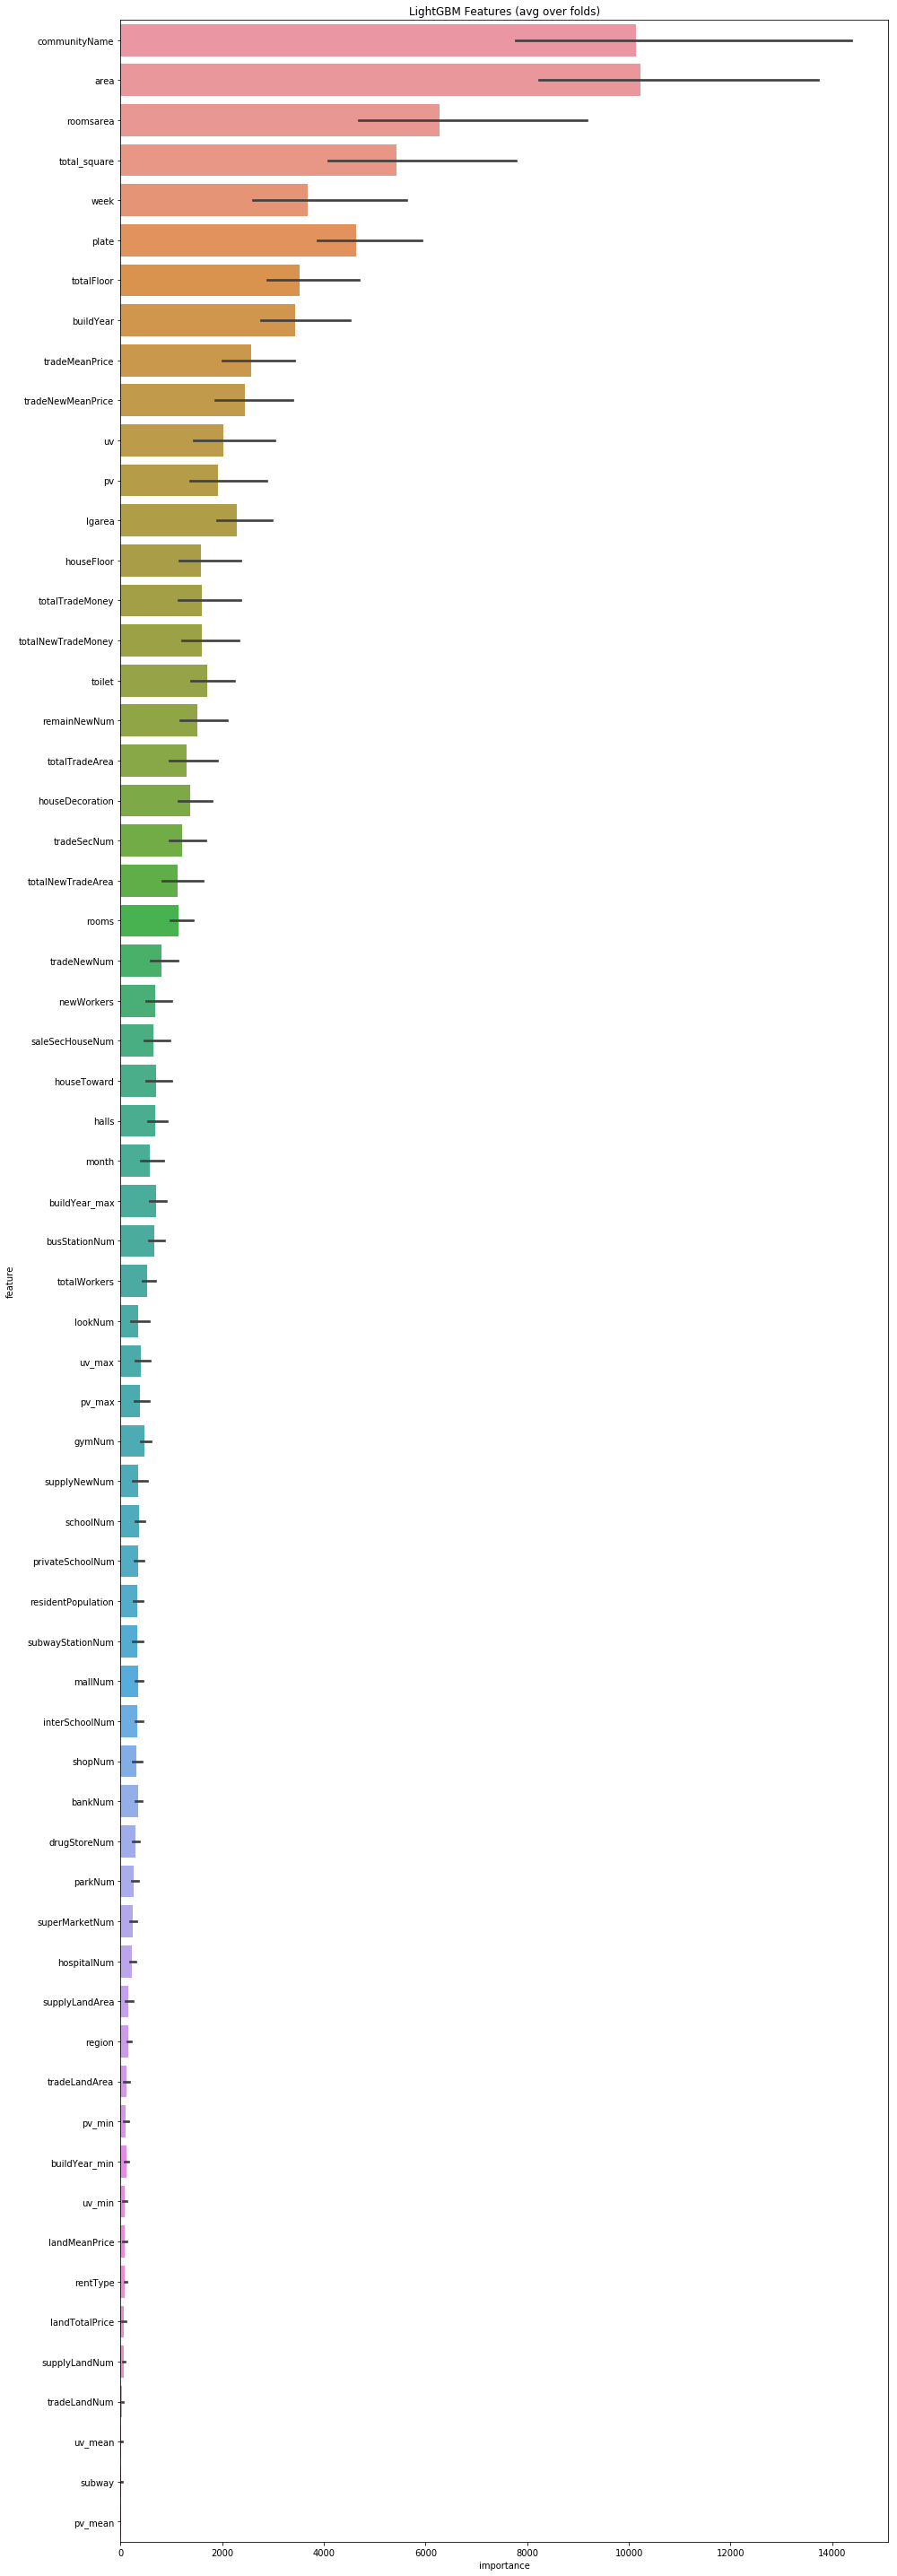

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# 生成提交数据

In [19]:
pd.DataFrame(predictions_lgb).apply(round).to_csv('submit-0.90085.csv',na_rep='\n',index=False,encoding='utf8',header=False)